In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing, model_selection
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('../data/merged.csv')

In [3]:
X = df.drop(columns=['ruid', 'visit_id', 'admit_date', 'discharge_date', 'readmit_time', 
                     'total_encounters', 'dob', 'dod'])

## Training-Validation-Testing Split

In [4]:
train = X[X.group=='train']
train.drop(columns='group', inplace=True)

valid = X[X.group=='valid']
valid.drop(columns='group', inplace=True)

test = X[X.group=='test']
test.drop(columns='group', inplace=True)

assert(X.shape[0]==(train.shape[0] + valid.shape[0] + test.shape[0]))

/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Patterns of Missingness

In [5]:
%load_ext rpy2.ipython

In [6]:
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
%R install.packages('Hmisc', dependencies=T)

Selection:  67


--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]                   2: Algeria [https]                
 3: Australia (Canberra) [https]      4: Australia (Melbourne 1) [https]
 5: Australia (Melbourne 2) [https]   6: Australia (Perth) [https]      
 7: Austria [https]                   8: Belgium (Ghent) [https]        
 9: Brazil (PR) [https]              10: Brazil (RJ) [https]            
11: Brazil (SP 1) [https]            12: Brazil (SP 2) [https]          
13: Bulgaria [https]                 14: Chile 1 [https]                
15: Chile 2 [https]                  16: China (Hong Kong) [https]      
17: China (Guangzhou) [https]        18: China (Lanzhou) [https]        
19: China (Shanghai 1) [https]       20: China (Shanghai 2) [https]     
21: Colombia (Cali) [https]          22: Czech Republic [https]         
23: Denmark [https]                  24: East Asia [https]              
25: Ecuador (Cuenca) [https]         26: E

In [7]:
%R library(Hmisc)


Error in library(Hmisc) : there is no package called ‘Hmisc’


In [10]:
%%R -i valid -o valid_imp

# ensure all variables have appropriate R structures
valid$sex <- as.factor(valid$sex)
valid$race <- as.factor(valid$race)
#valid$pregnancy_indicator <- as.factor(valid$pregnancy_indicator)
valid$readmit_30d <- as.factor(valid$readmit_30d)

med_imp <- function(x) {
    if (is.numeric(x)) {
        x <- as.numeric(impute(x, fun=median))
    }
    else {
        x <- as.factor(x)
    }
}

valid_imp <- data.frame(lapply(valid, FUN=med_imp))


Error in impute(x, fun = median) : could not find function "impute"


/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [9]:
%%R -i test -o test_imp

# ensure all variables have appropriate R structures
test$sex <- as.factor(test$sex)
test$race <- as.factor(test$race)
#test$pregnancy_indicator <- as.factor(test$pregnancy_indicator)
test$readmit_30d <- as.factor(test$readmit_30d)

test_imp <- data.frame(lapply(test, FUN=med_imp))

In [10]:
%%R -i train
# ensure all variables have appropriate R structures
train$sex <- as.factor(train$sex)
train$race <- as.factor(train$race)
#train$pregnancy_indicator <- as.factor(train$pregnancy_indicator)

# include outcome variable in imputation
train$readmit_30d <- as.factor(train$readmit_30d)

In [11]:
%%R 
na.patterns.all <- naclus(train)

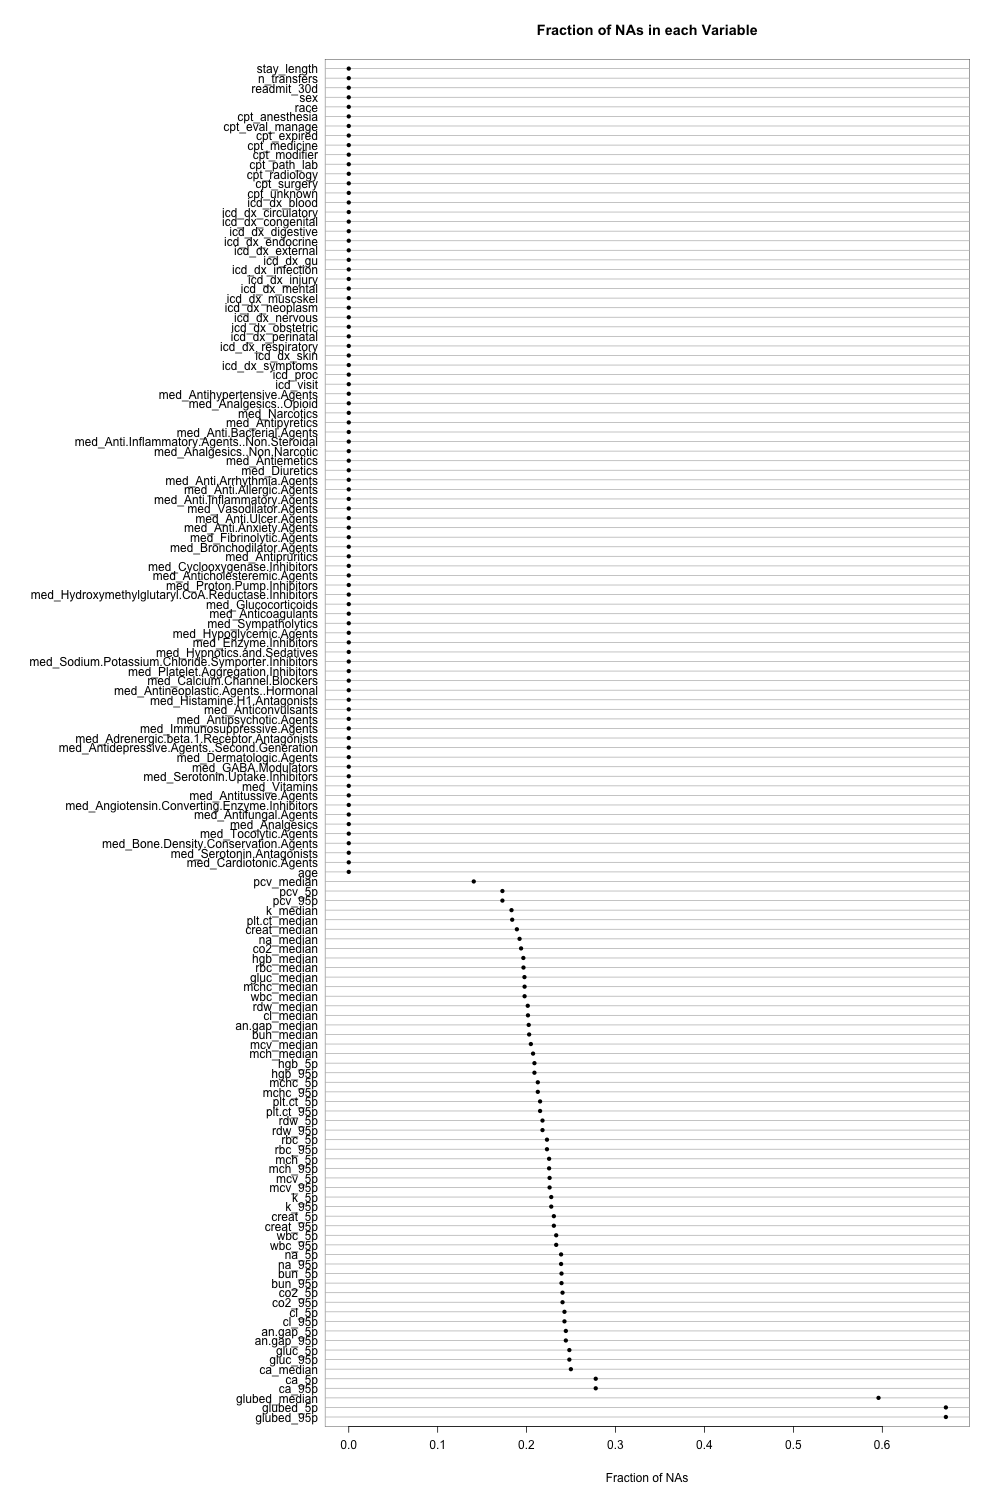

In [12]:
%%R -h 1500 -w 1000 -u px
naplot(na.patterns.all, which='na per var')

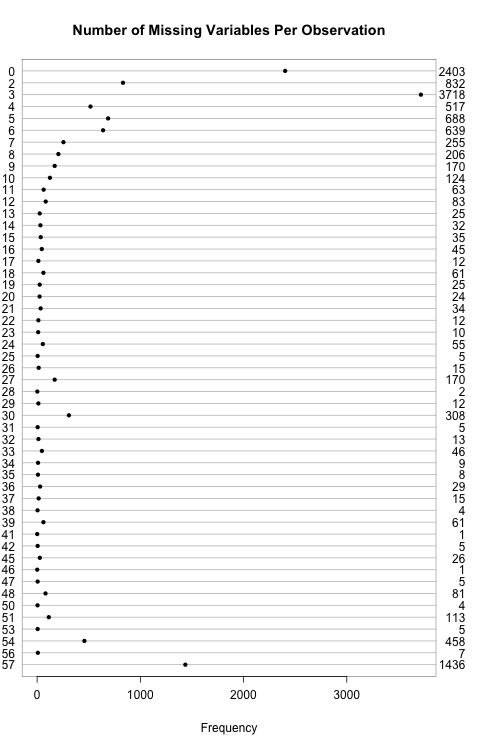

In [13]:
%%R -h 750 -w 480 -u px
naplot(na.patterns.all, which='na per obs')

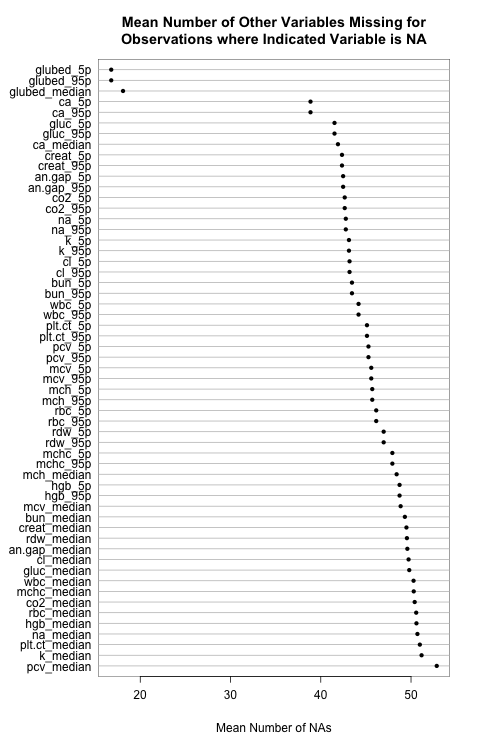

In [14]:
%%R -h 750 -w 480 -u px
naplot(na.patterns.all, which='mean na')

In [15]:
%%R

# separate categorical & numerical features
cat_cols <- c('sex', 'race', 'pregnancy_indicator', 'readmit_30d')
num_cols <- names(train[, !names(train) %in% cat_cols])

# convert all predictors into R formula
vars <- paste(num_cols, collapse=' + ')
formula <- paste('~', vars)

# attempting all variables (but singular matrix resulted)
#formula <- as.formula(paste(formula), ' + sex-1 + race-1 + pregnancy_indicator-1'))

# numerical values only
formula <- as.formula(paste(formula))

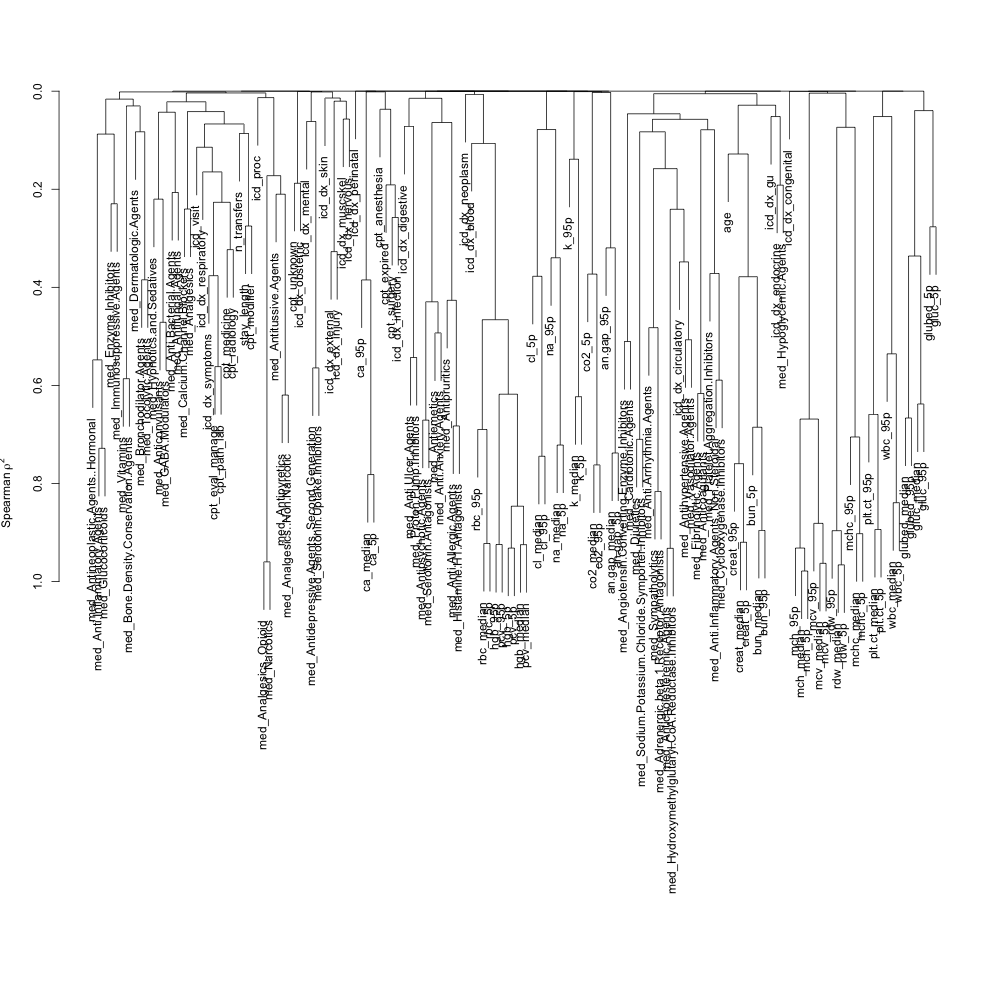

In [16]:
%%R -h 1000 -w 1000 -u px

vc <- varclus(formula, sim='spearman', data=train)
plot(vc) 

## Single Imputation with `Hmisc::transcan()` in R

*Note:* This step takes a while to run even with a single imputation.  It is recommended to load the existing .RData file in the subsequent step. 

Convergence criterion:3.329 2.094 
Convergence in 3 iterations
R-squared achieved in predicting each variable:

                                       stay_length 
                                             0.878 
                                       n_transfers 
                                             0.615 
                                       readmit_30d 
                                             0.088 
                                               sex 
                                             0.246 
                                              race 
                                             0.266 
                                    cpt_anesthesia 
                                             0.168 
                                   cpt_eval_manage 
                                             0.893 
                                       cpt_expired 
                                             0.778 
                                      cpt_medicine 
    

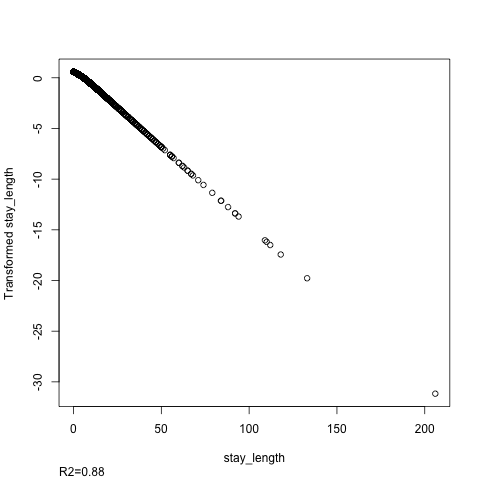

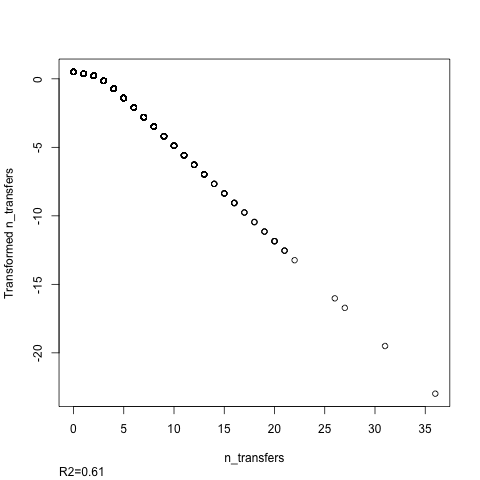

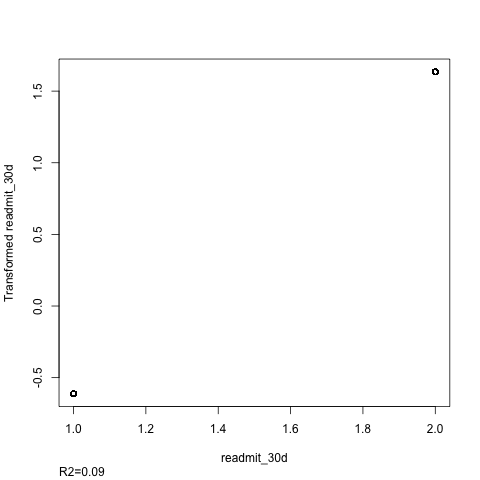

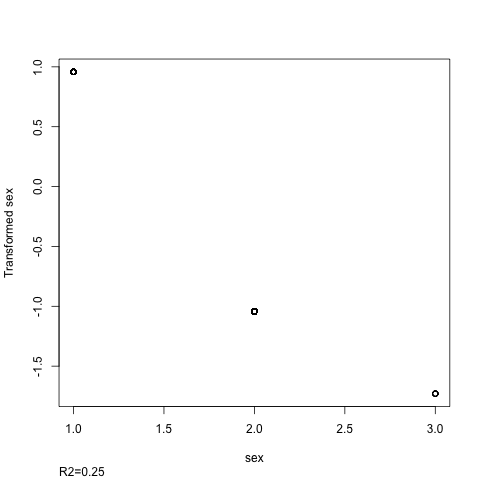

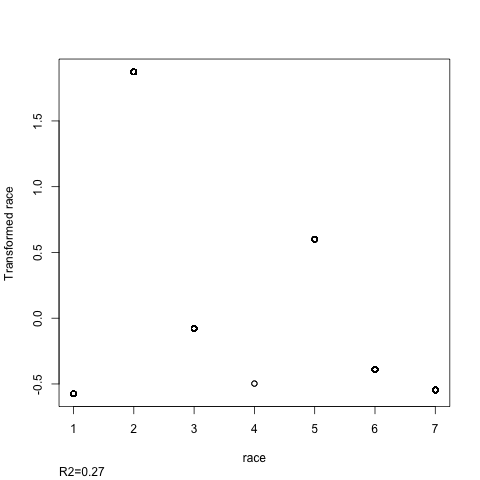

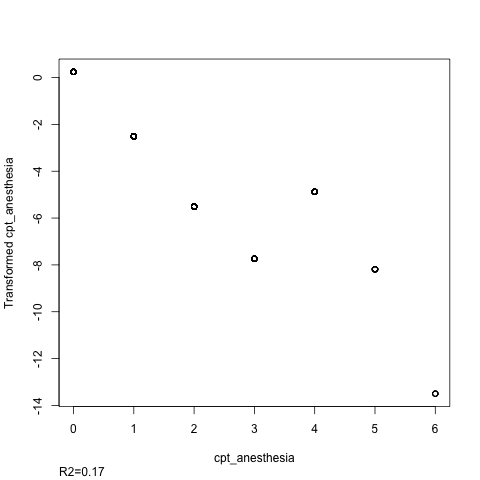

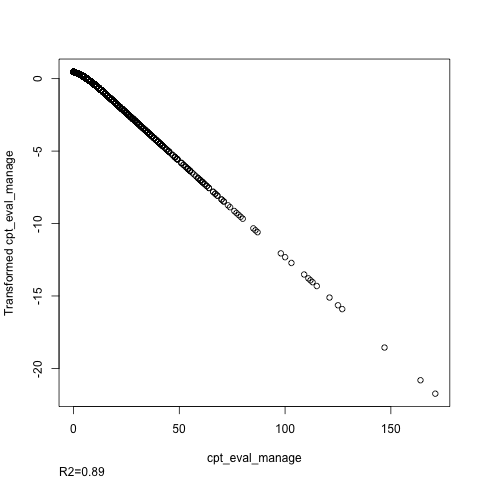

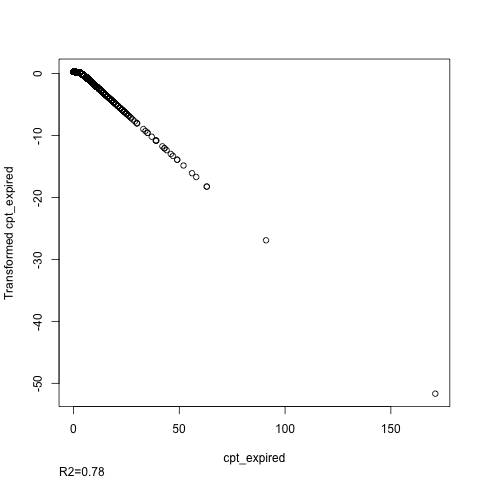

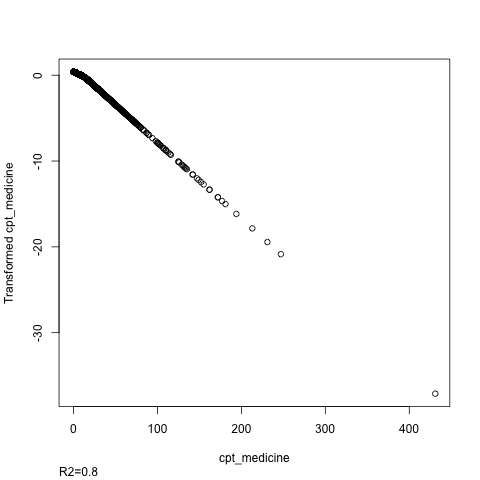

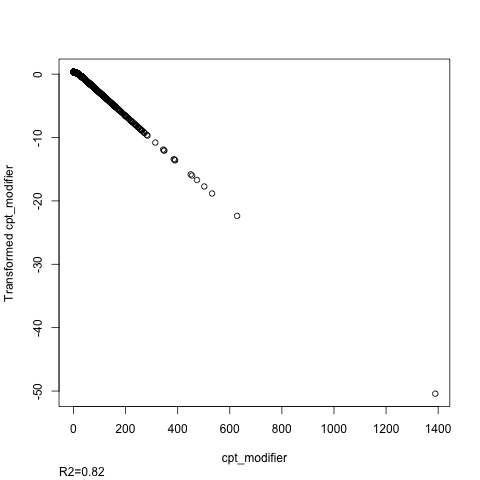

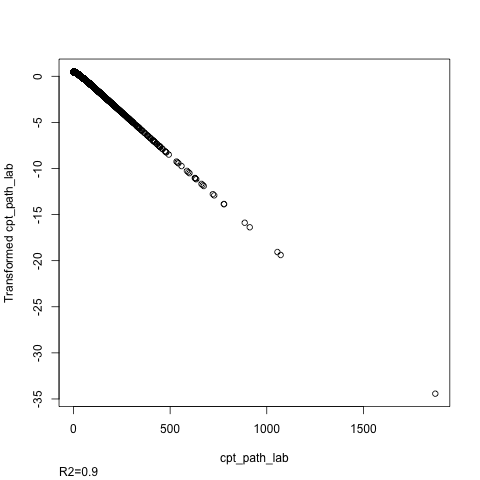

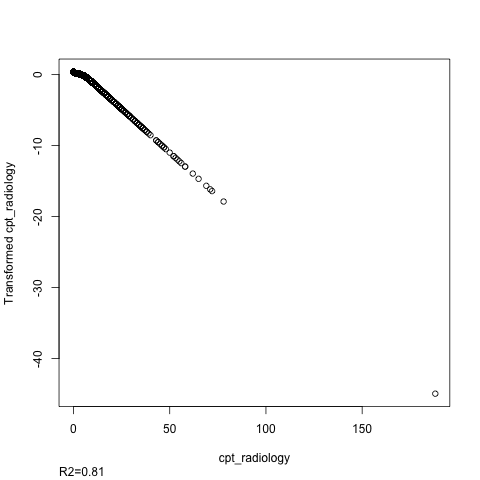

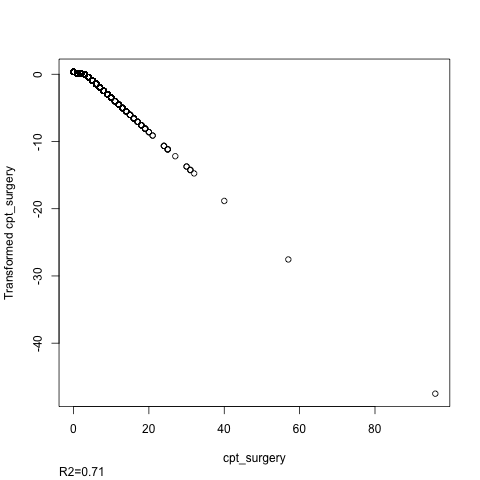

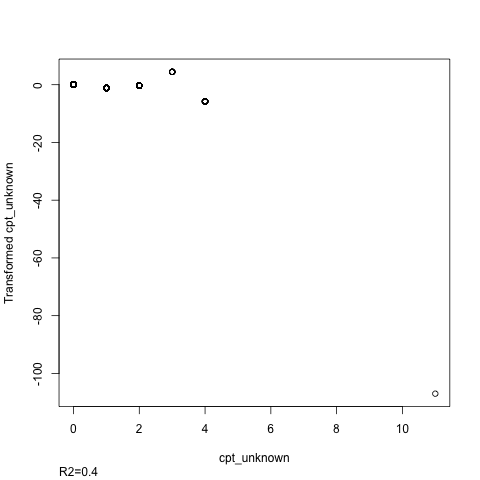

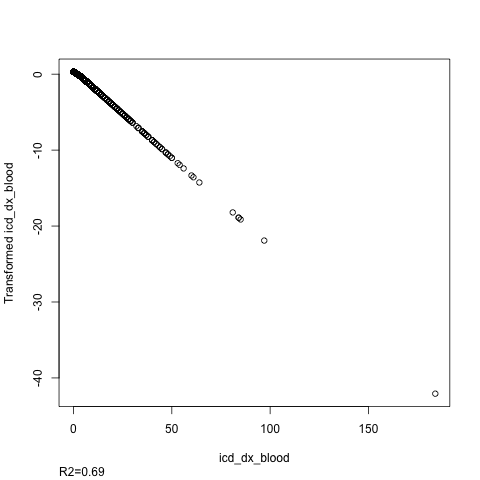

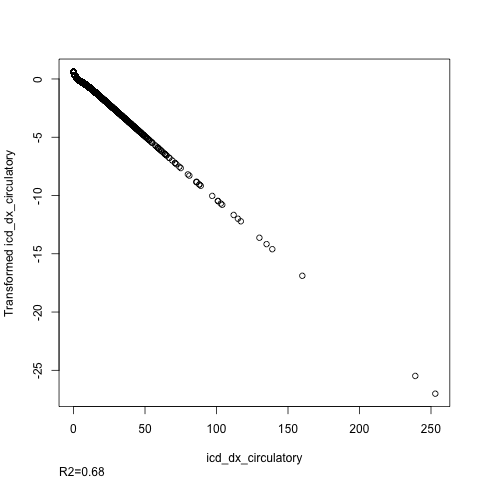

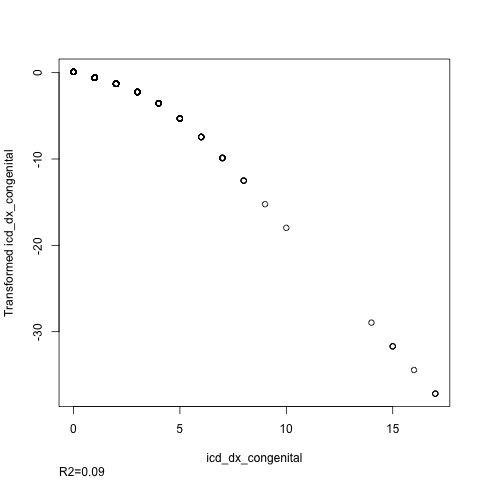

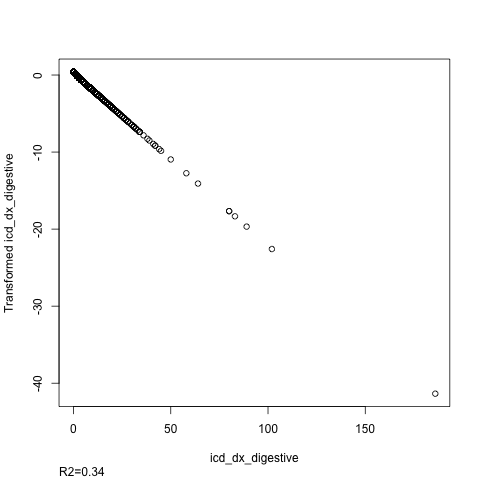

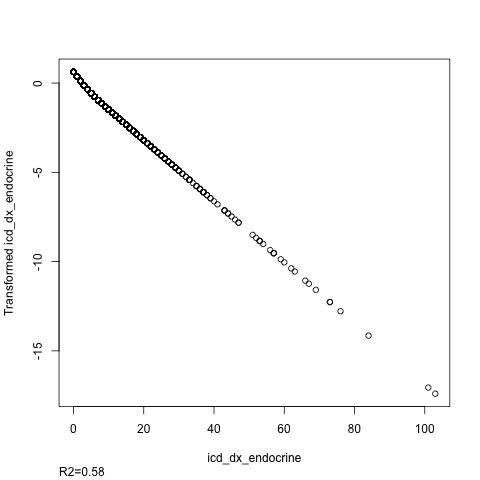

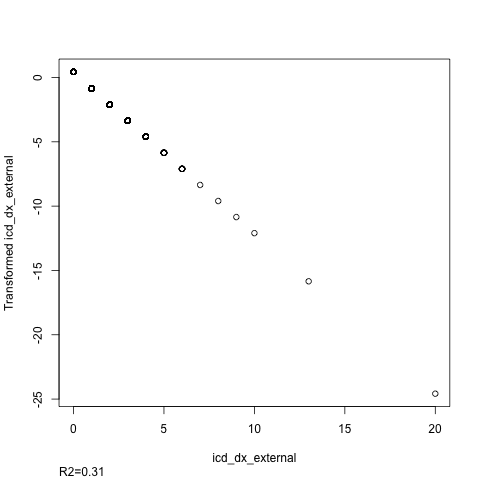

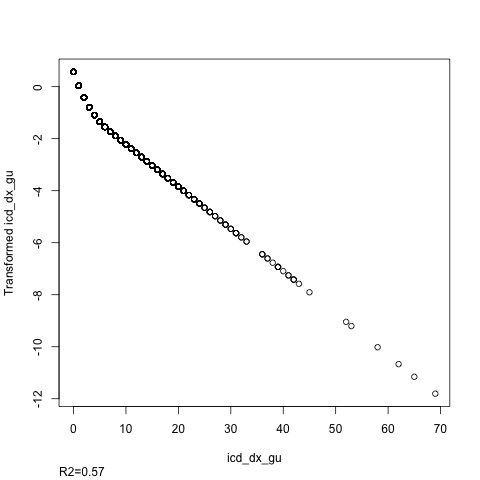

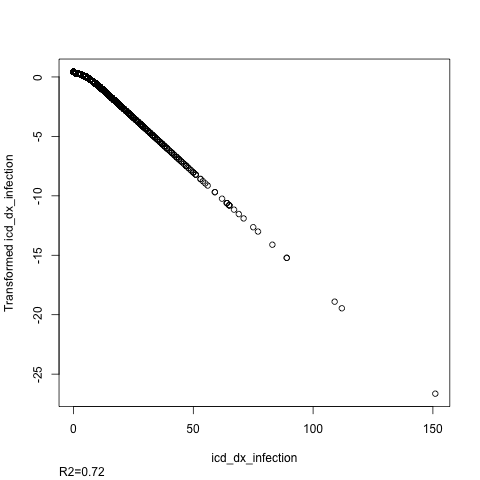

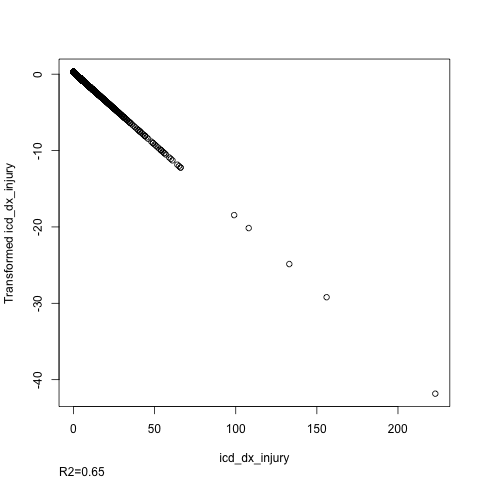

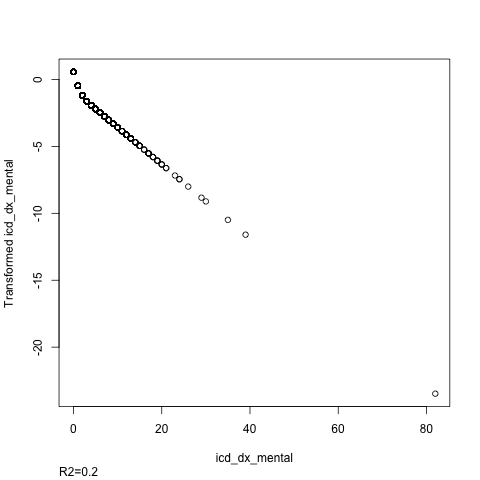

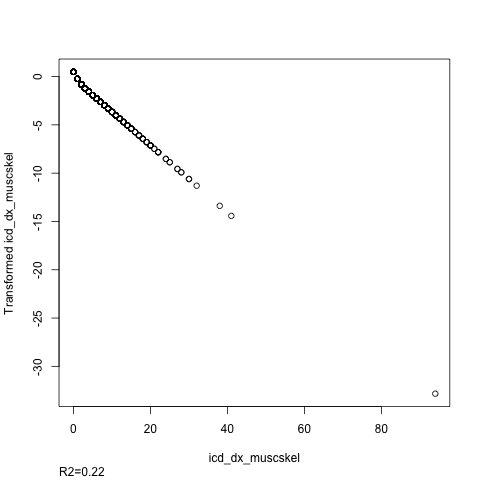

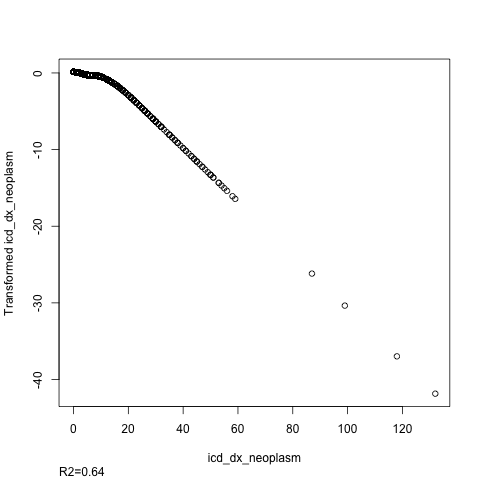

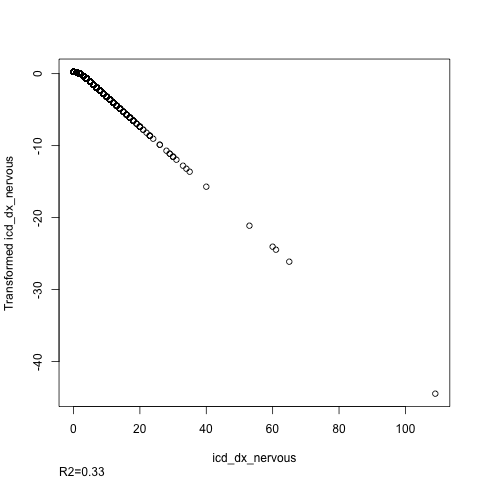

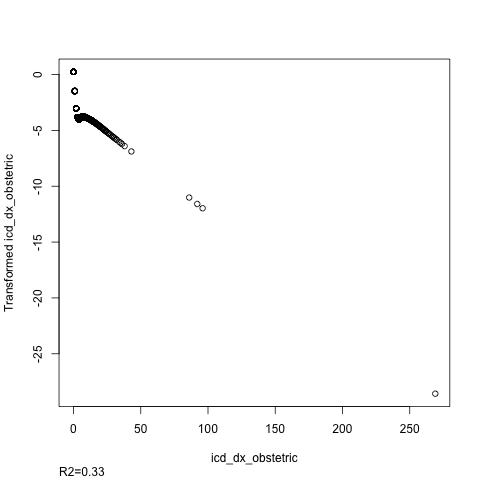

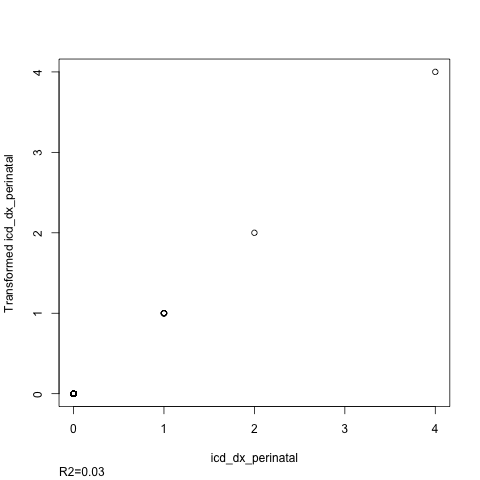

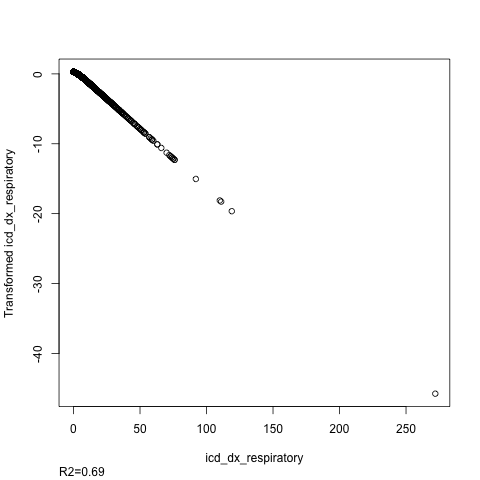

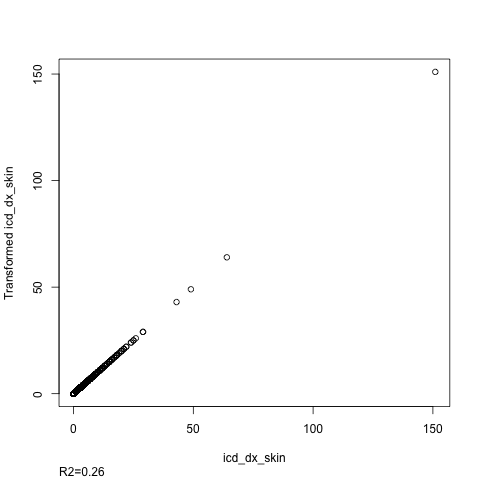

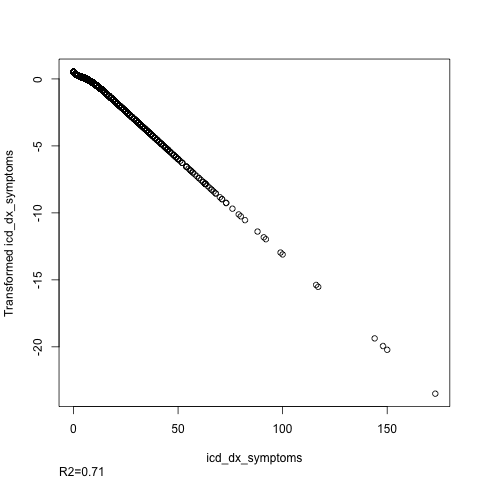

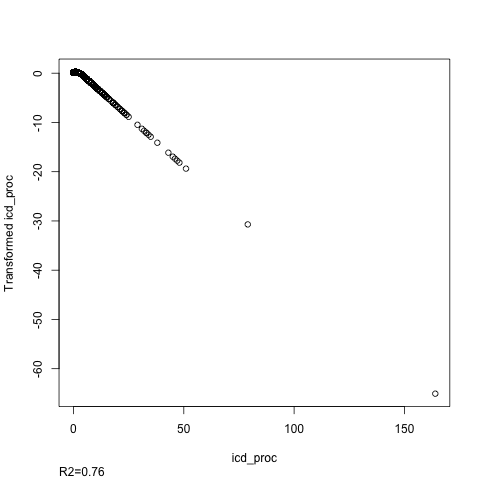

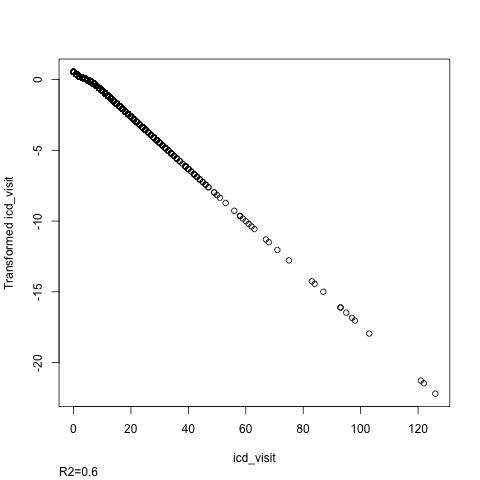

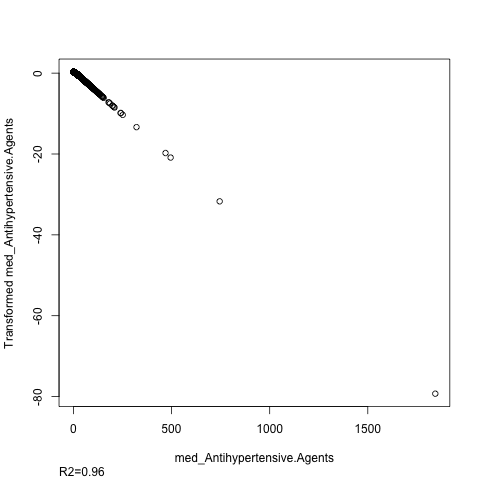

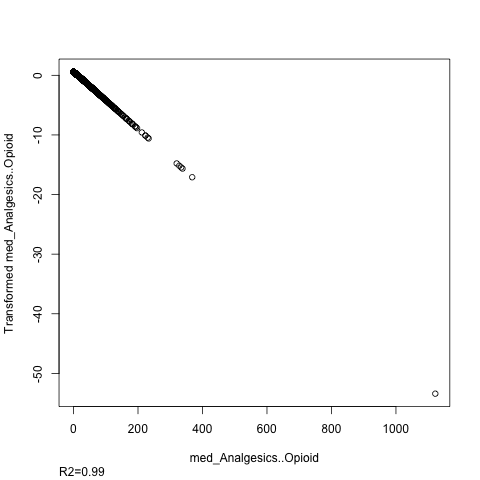

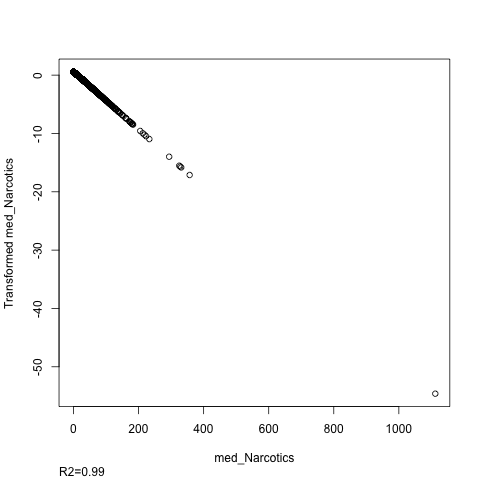

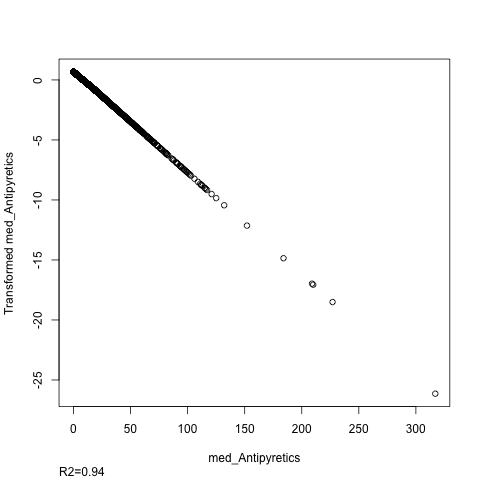

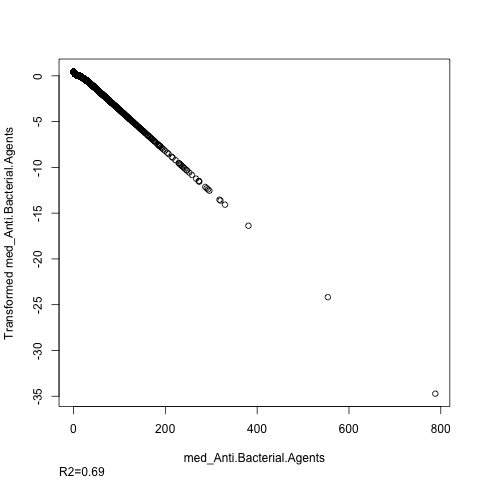

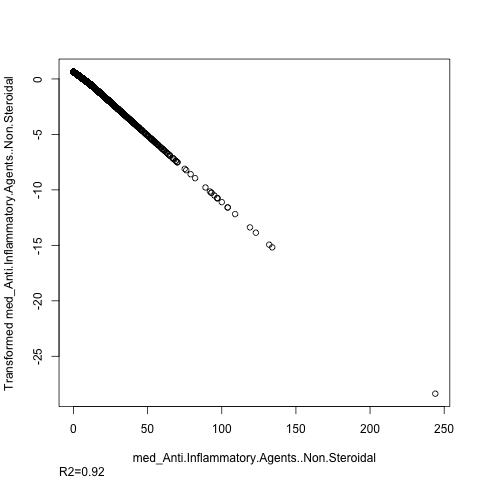

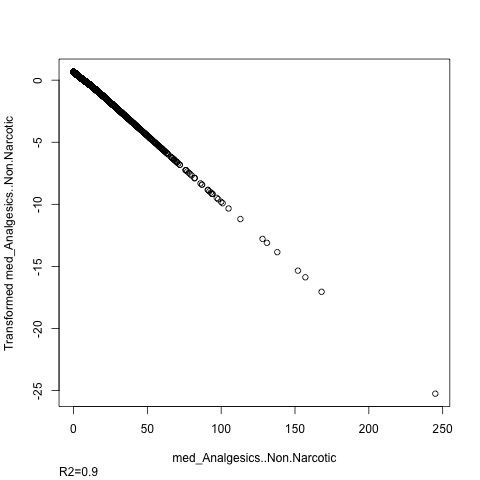

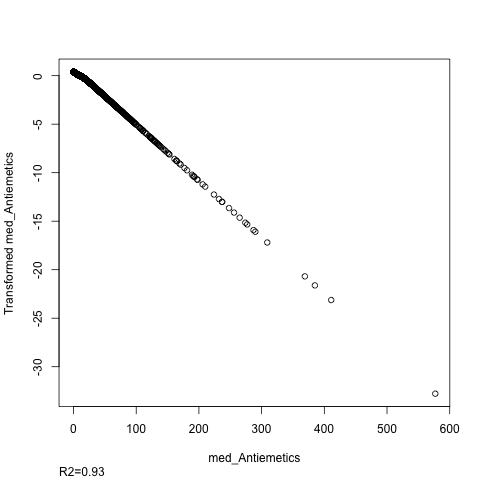

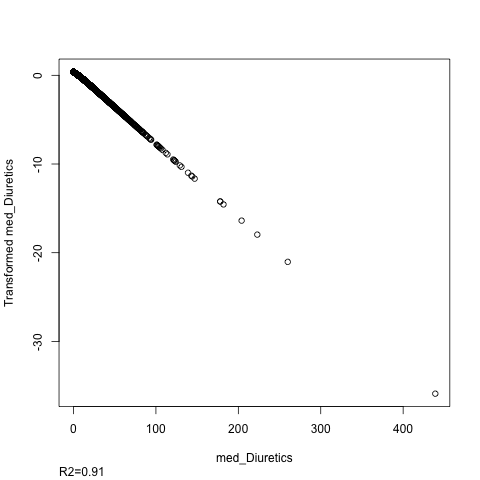

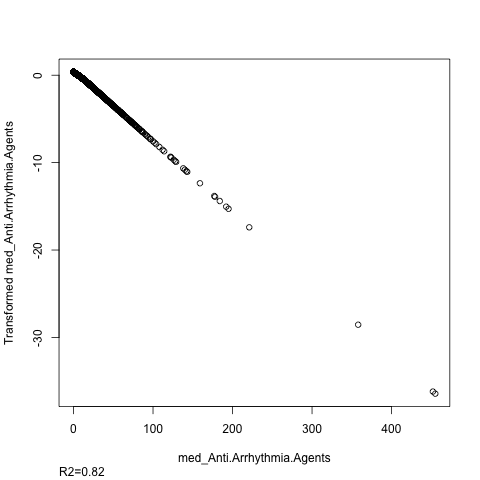

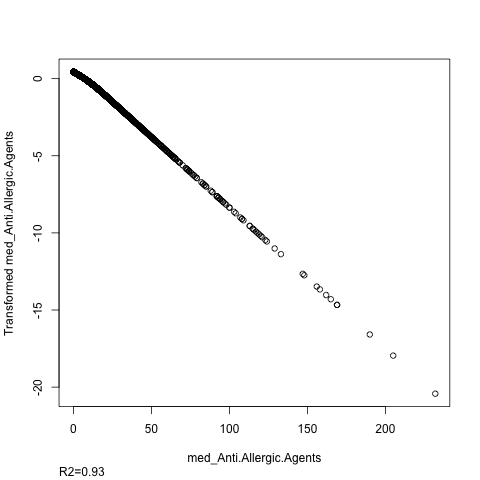

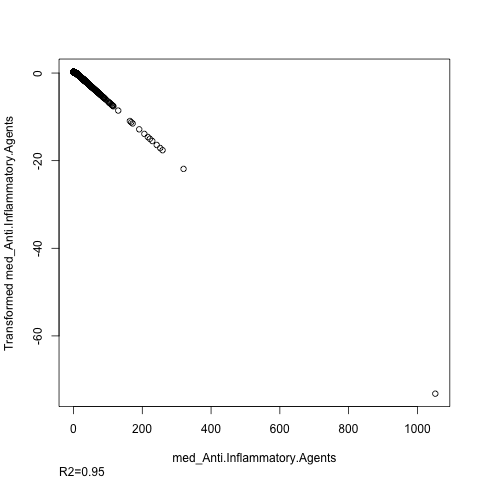

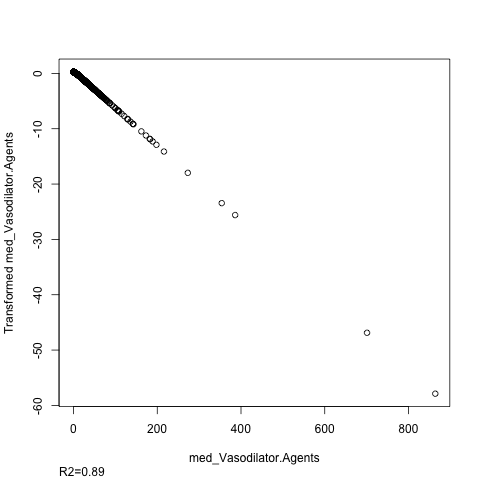

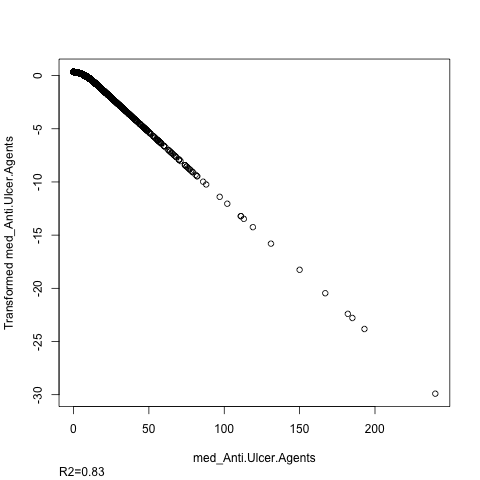

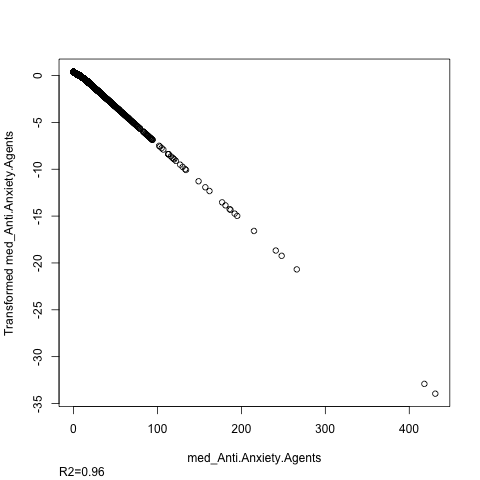

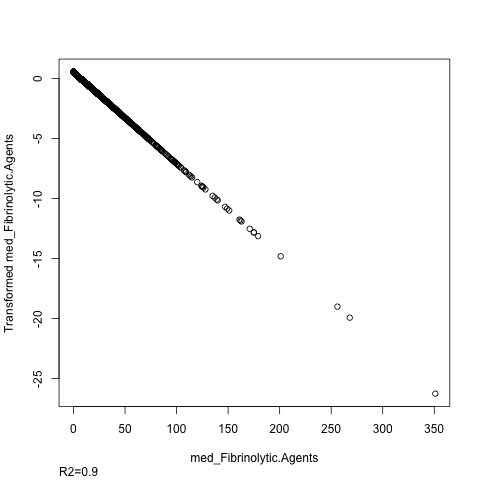

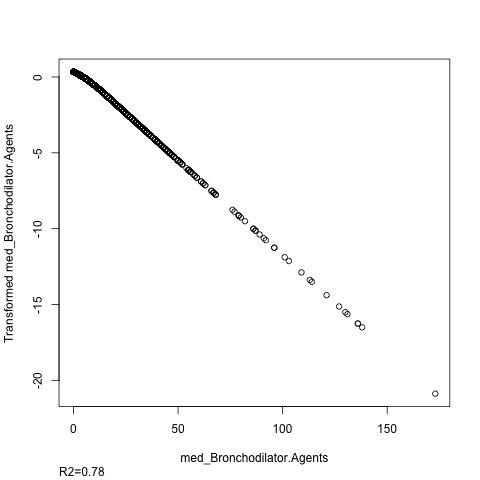

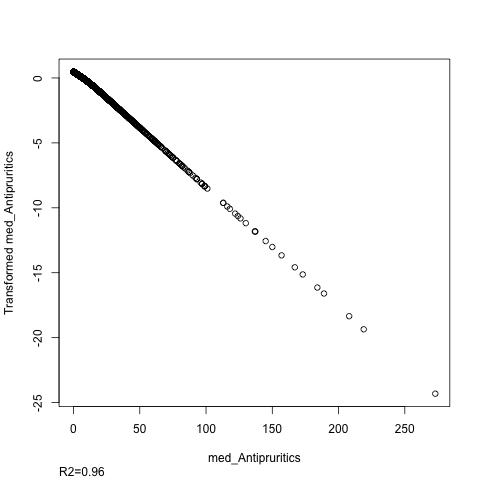

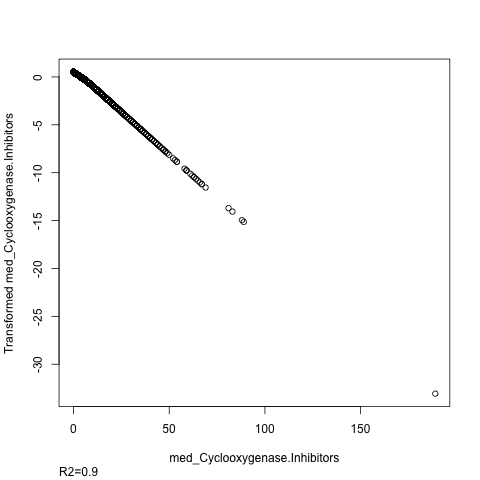

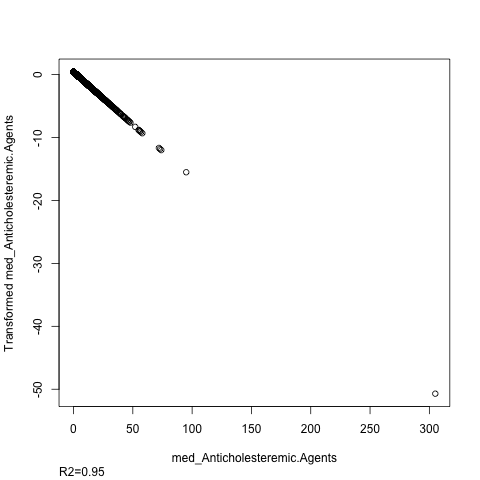

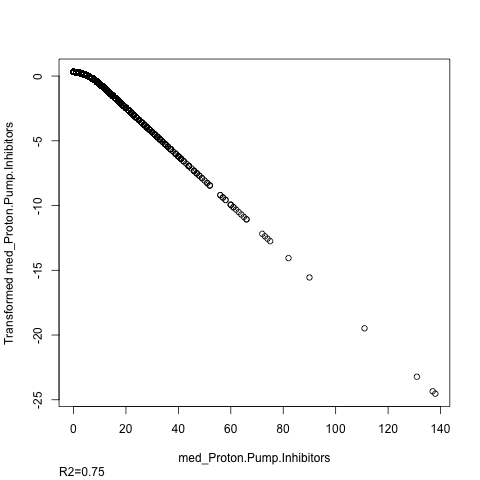

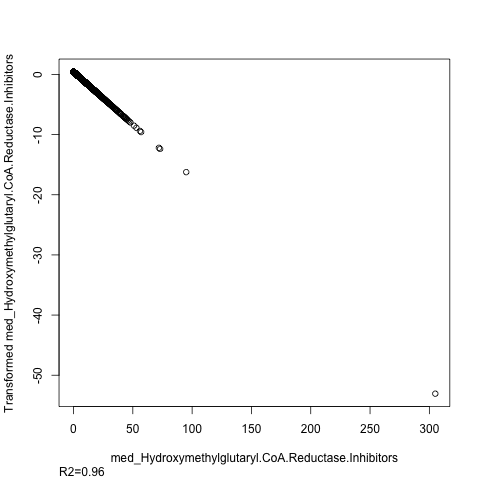

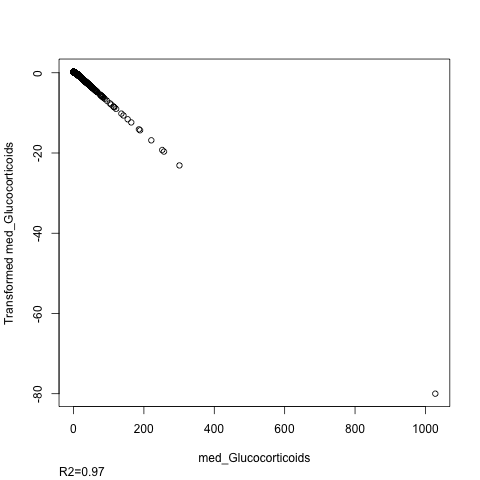

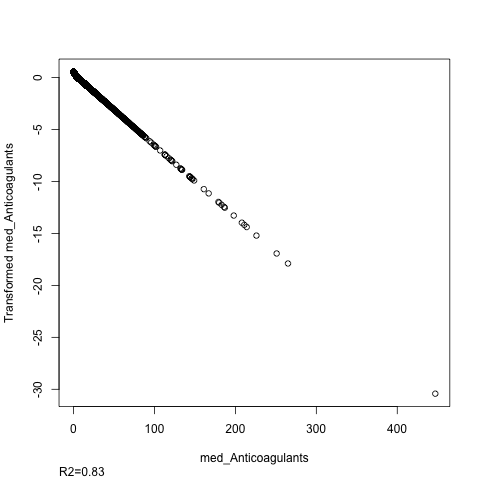

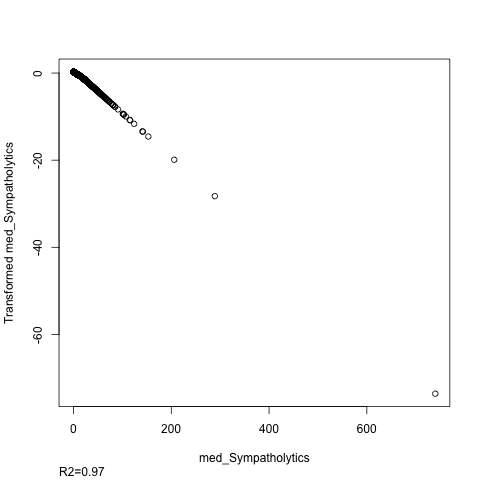

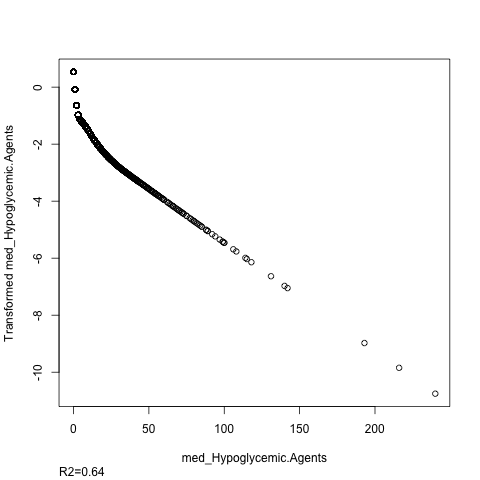

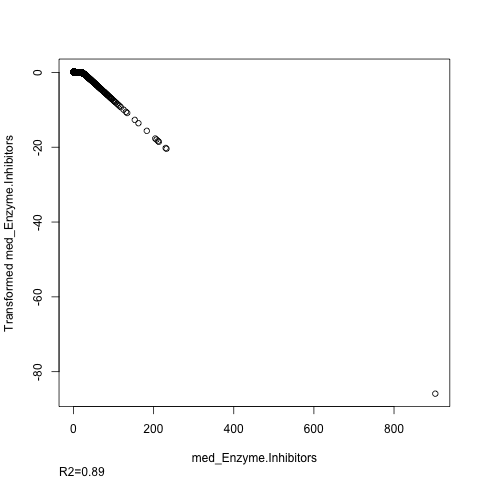

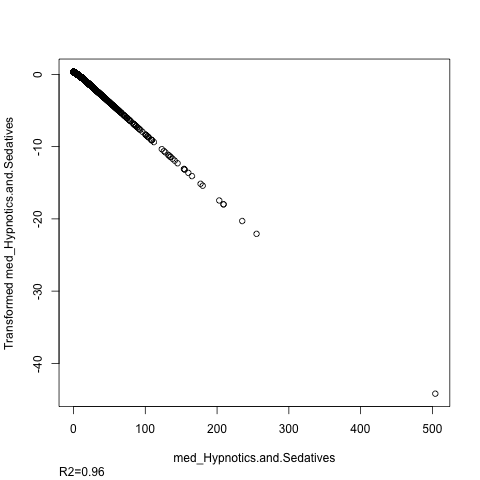

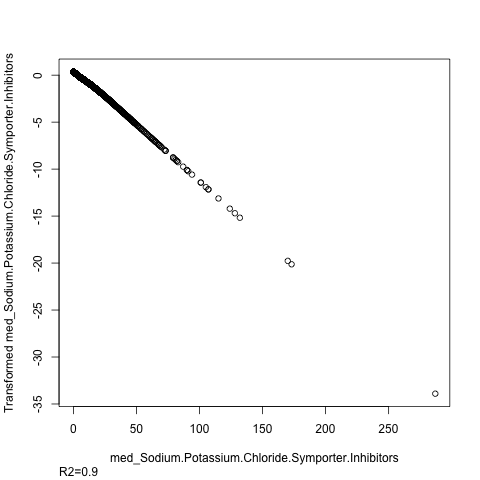

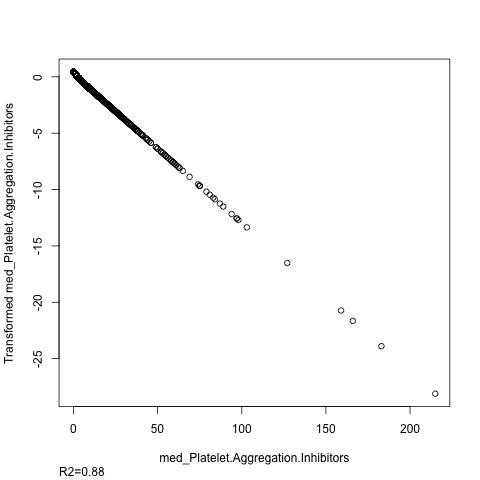

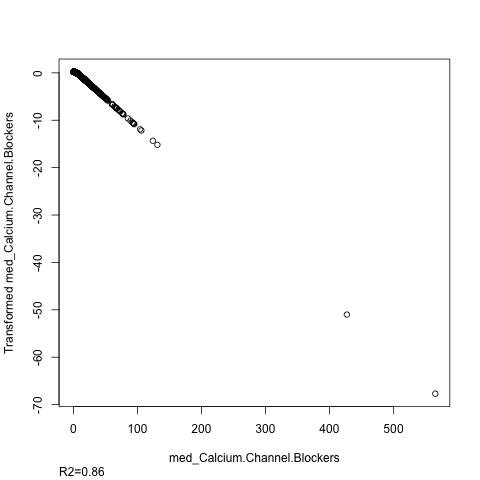

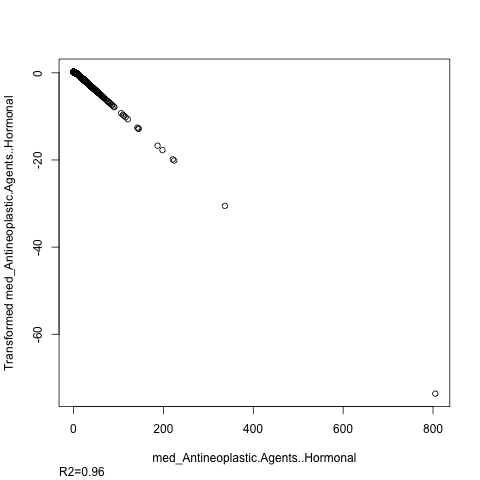

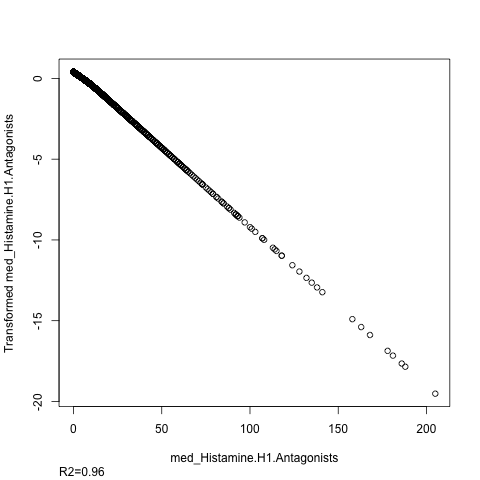

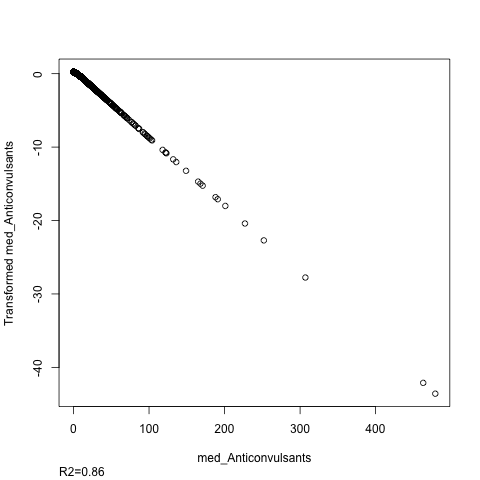

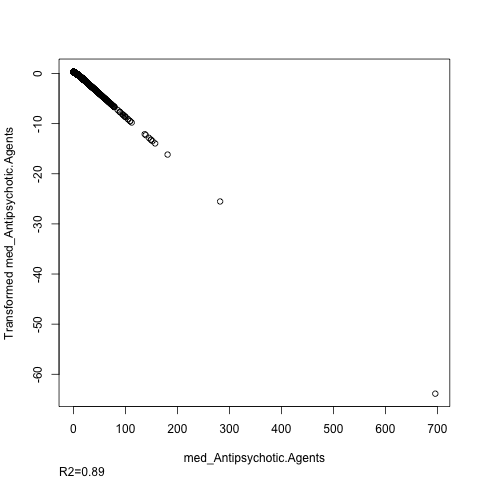

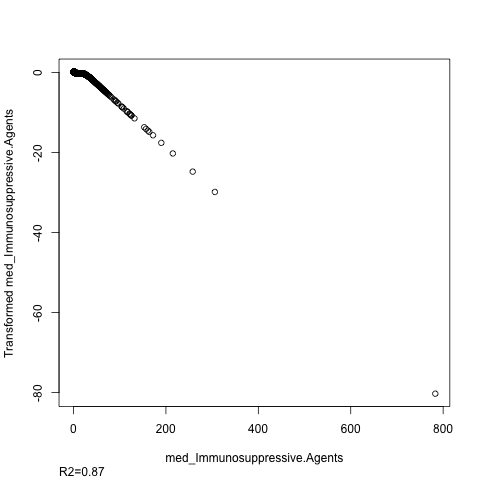

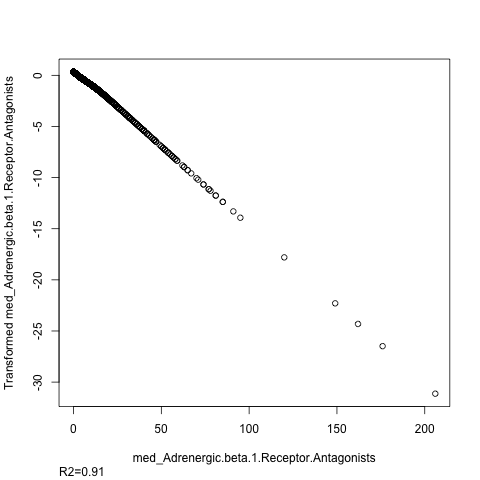

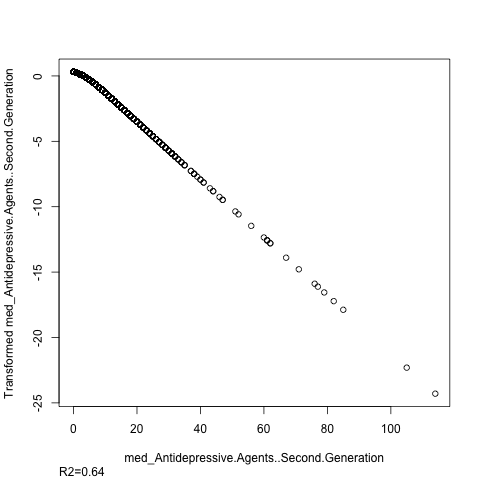

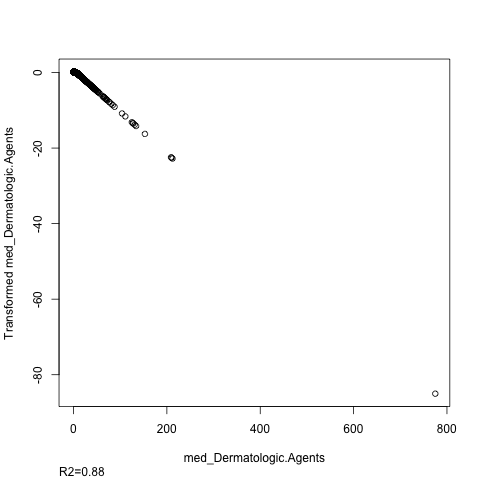

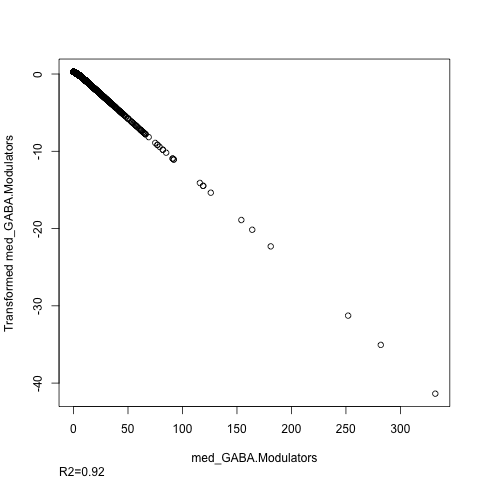

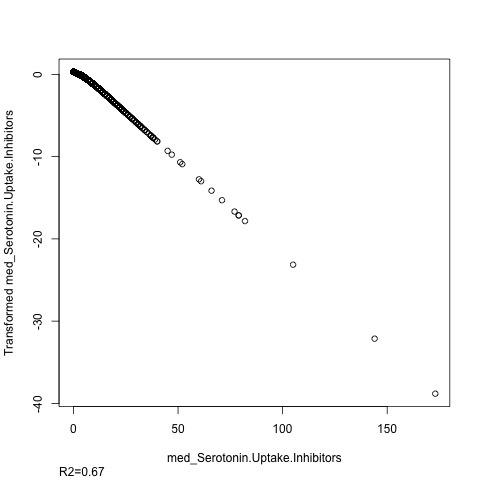

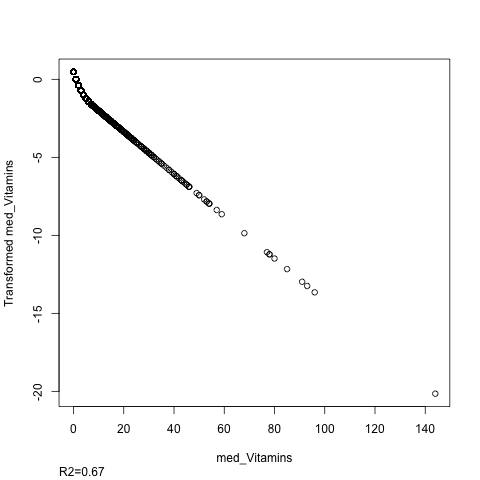

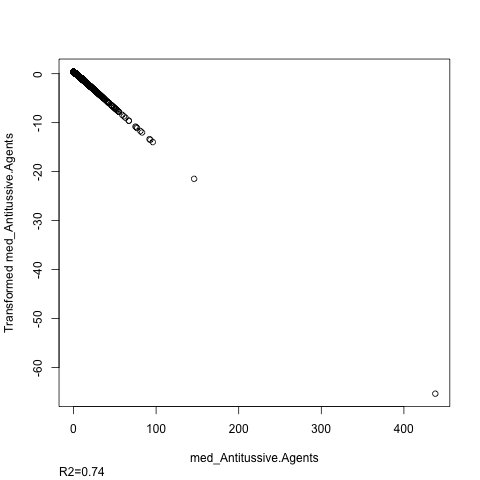

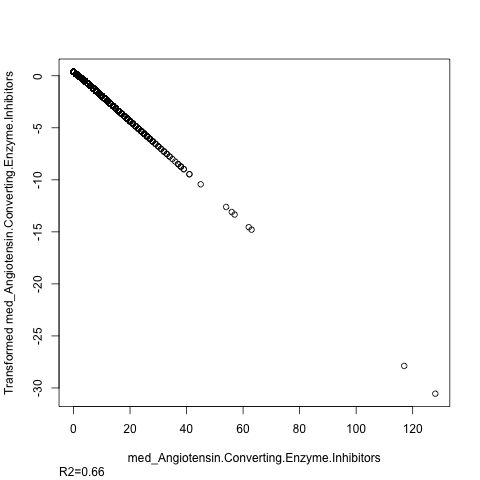

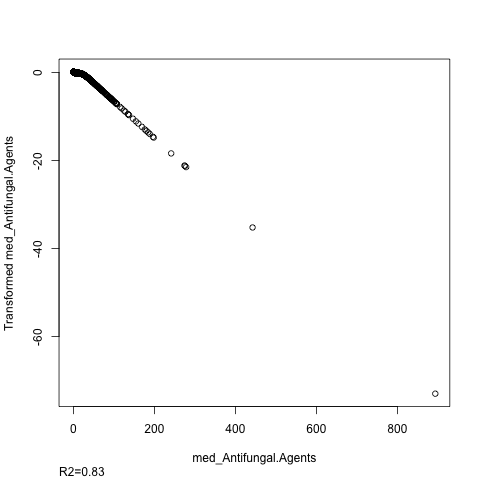

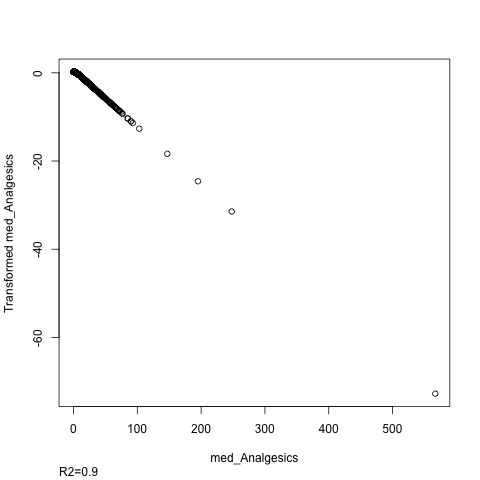

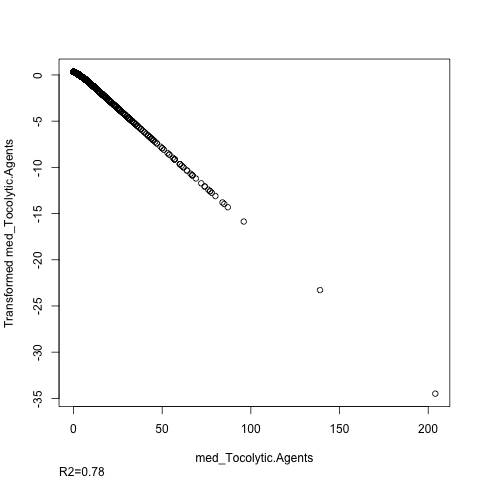

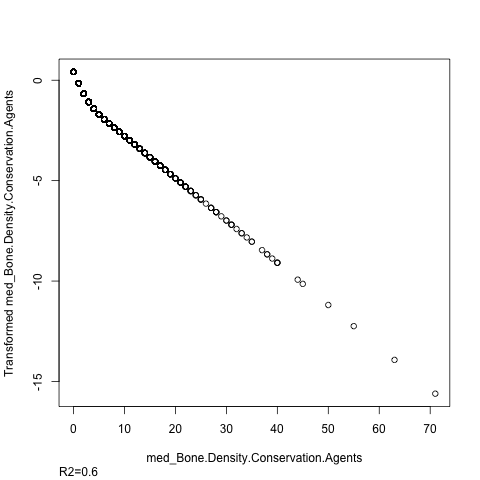

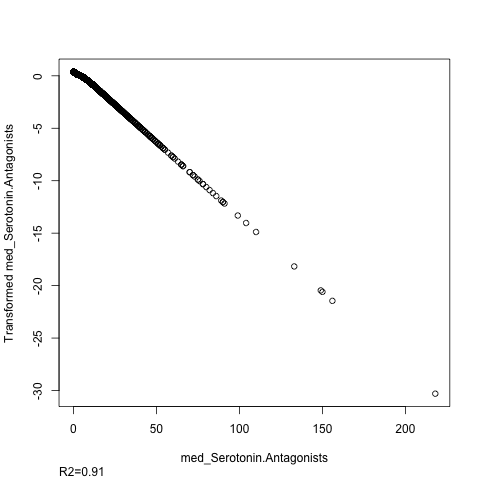

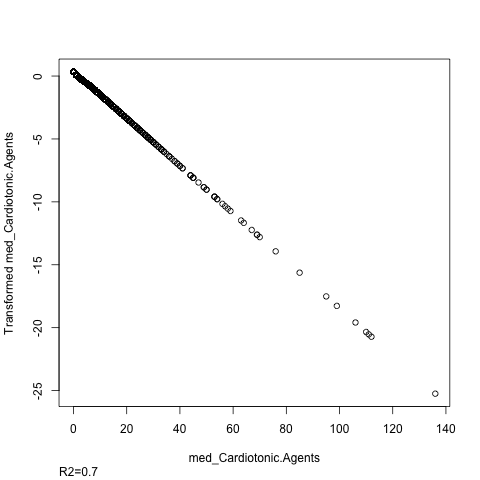

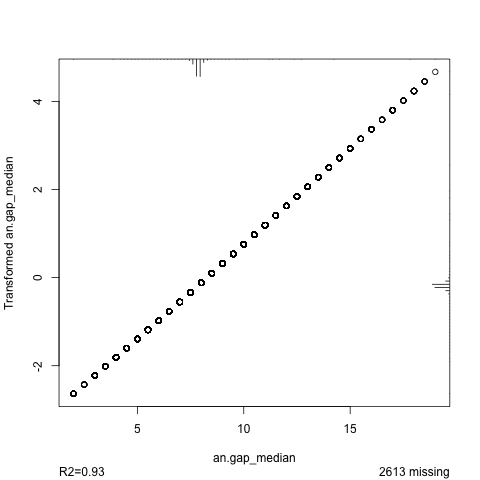

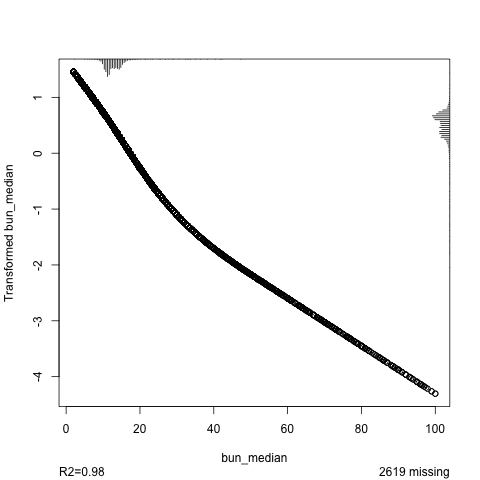

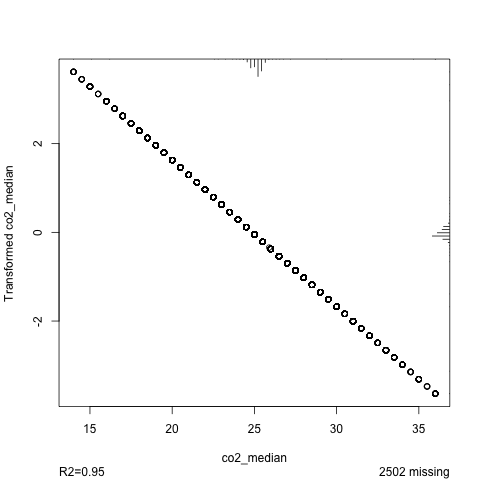

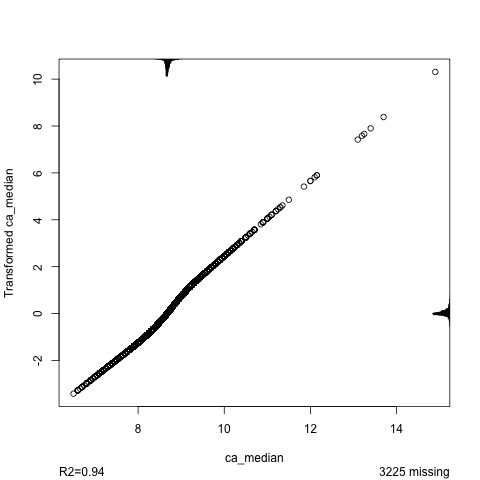

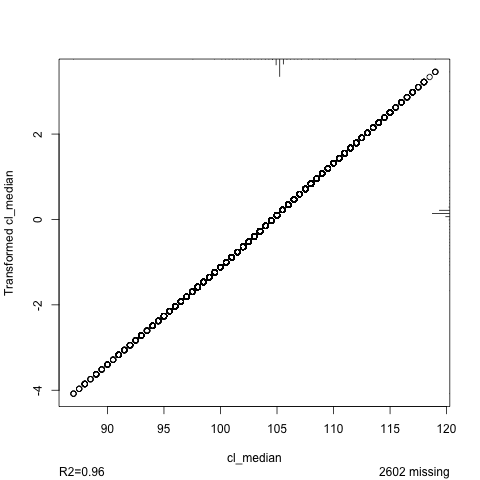

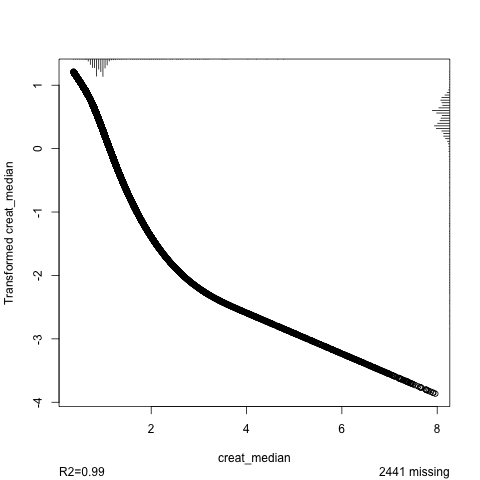

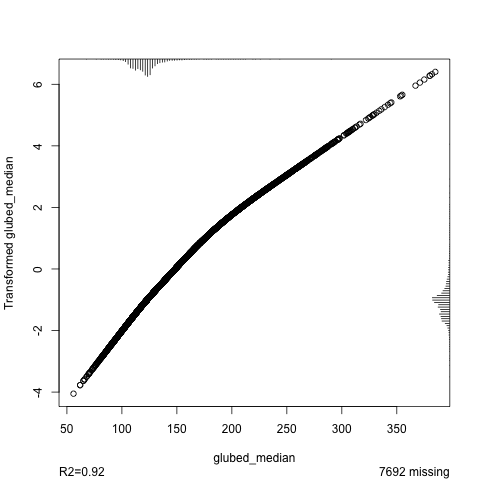

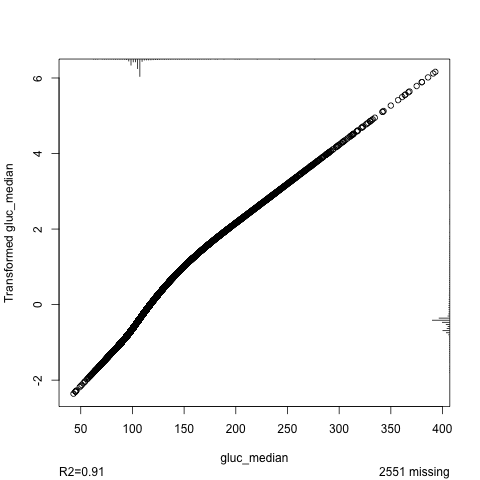

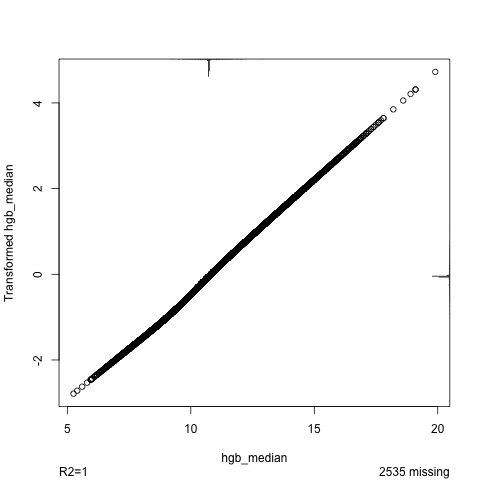

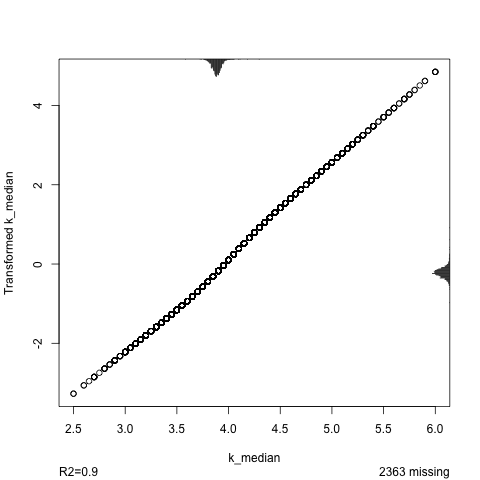

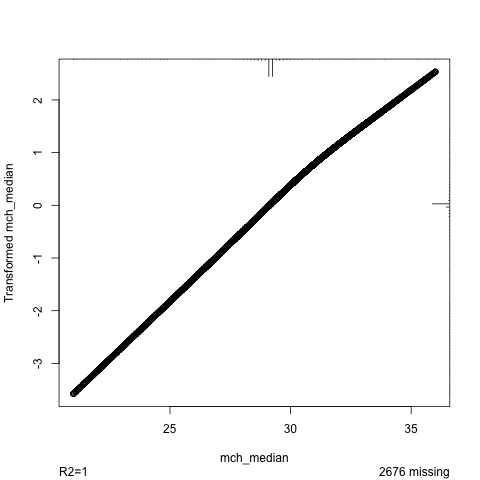

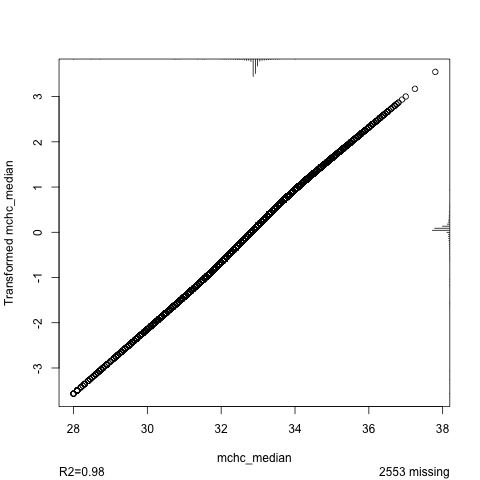

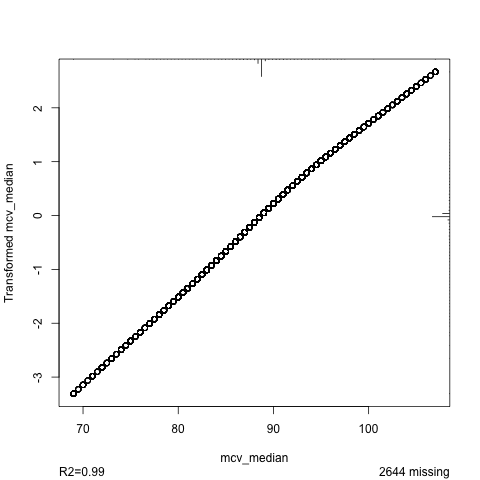

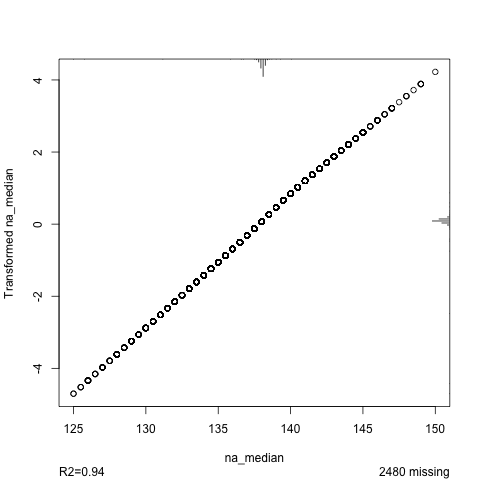

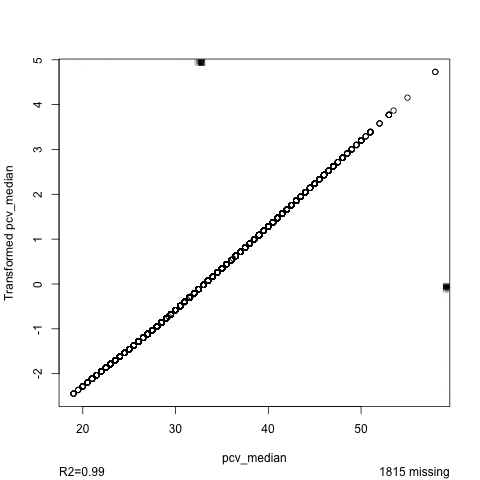

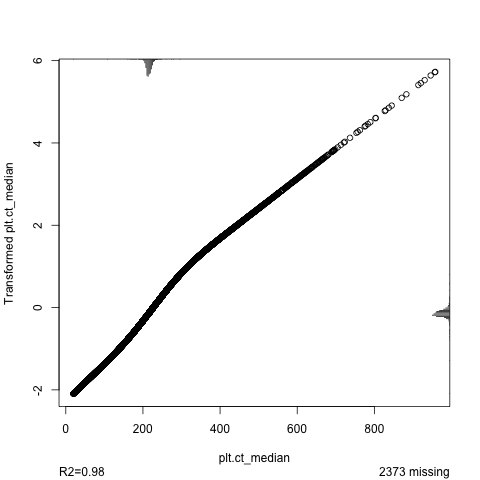

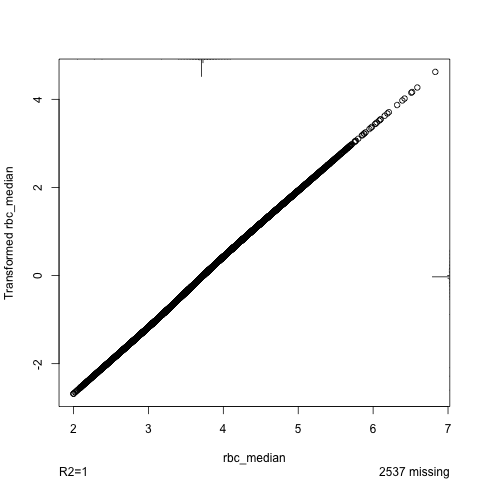

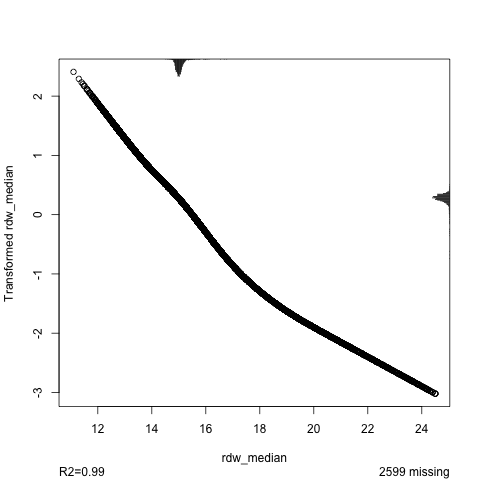

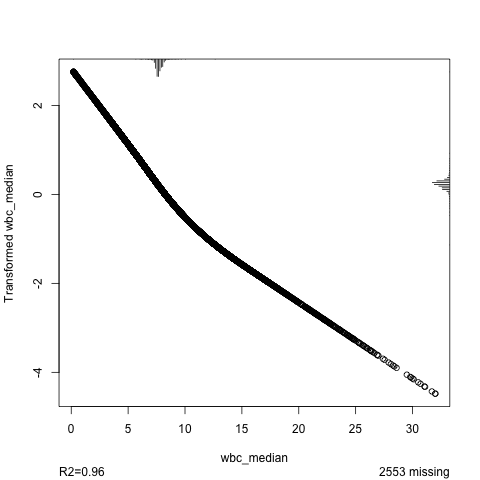

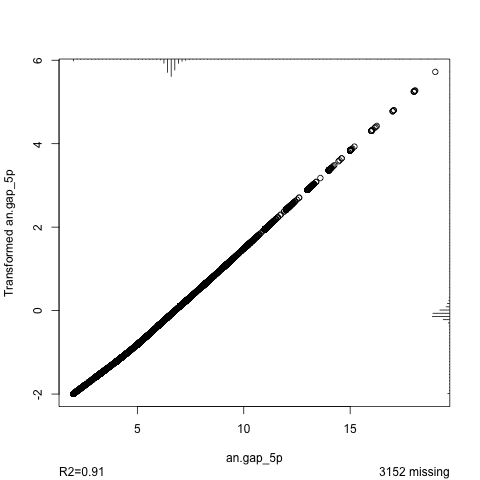

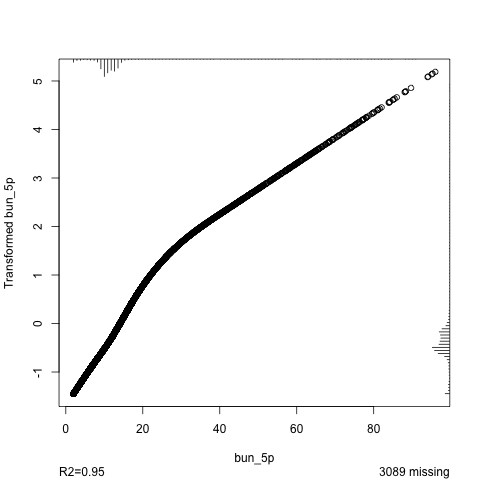

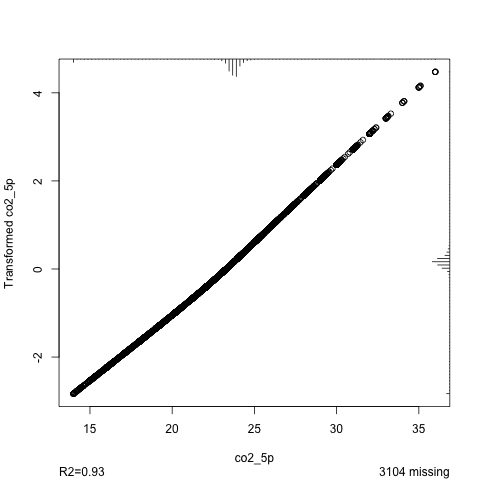

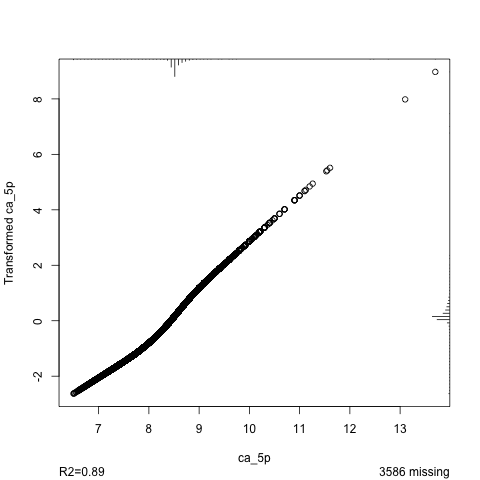

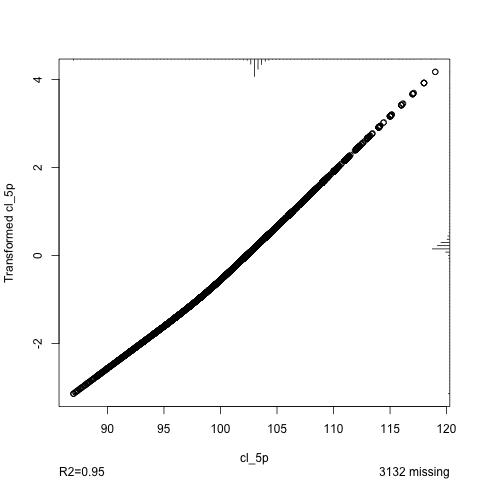

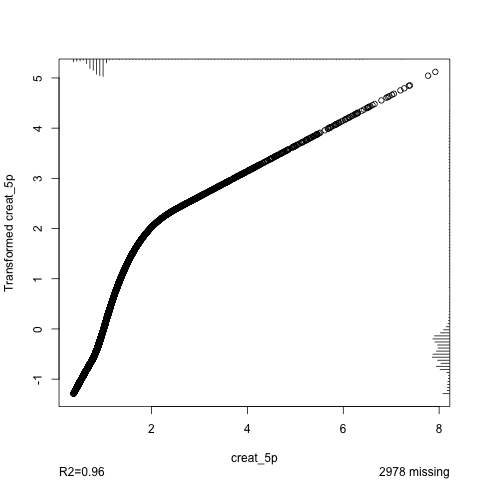

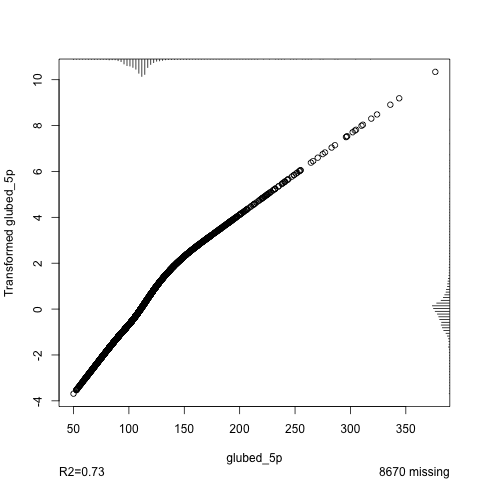

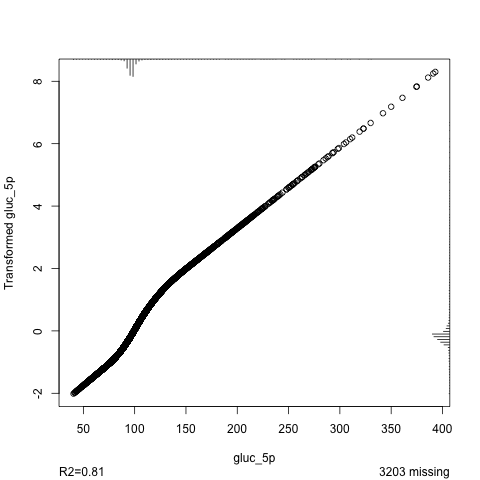

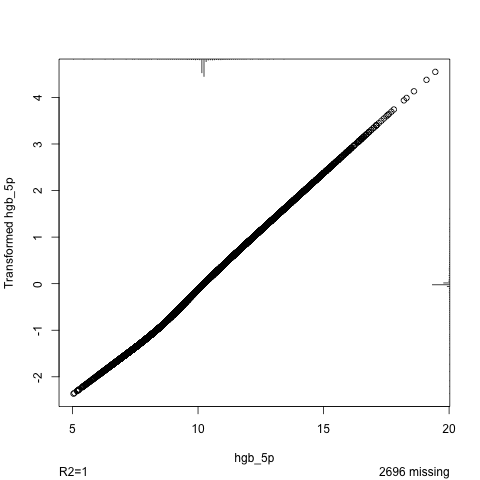

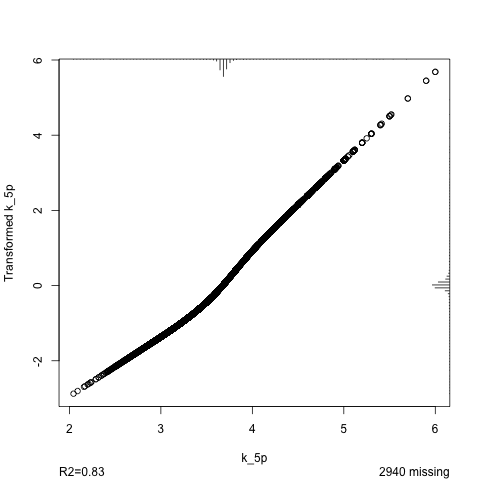

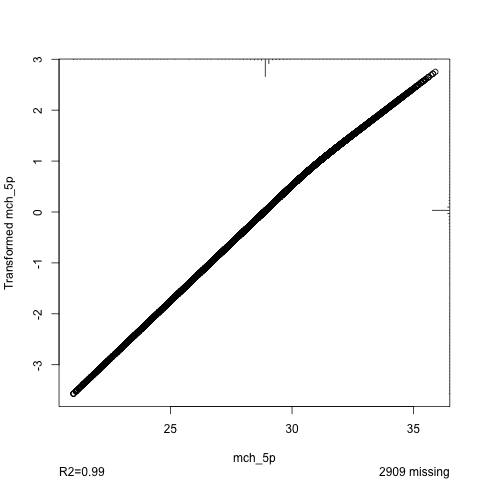

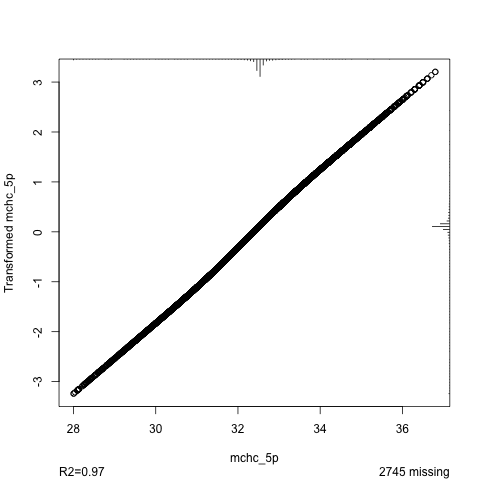

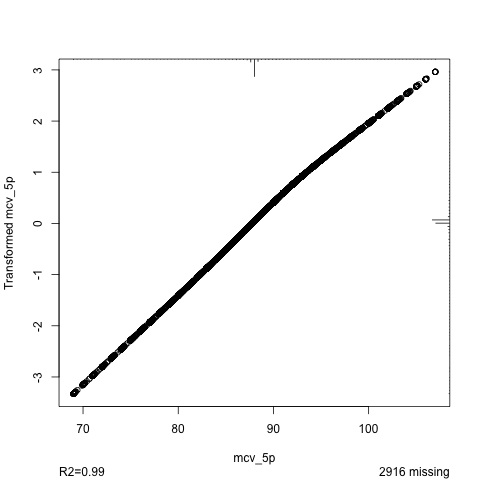

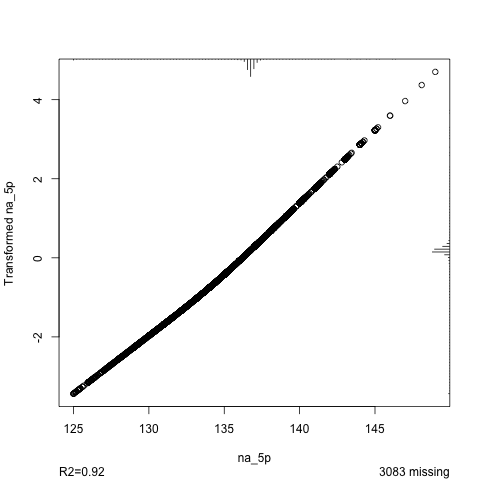

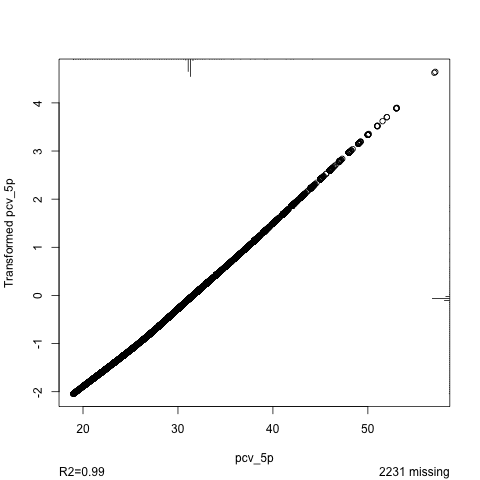

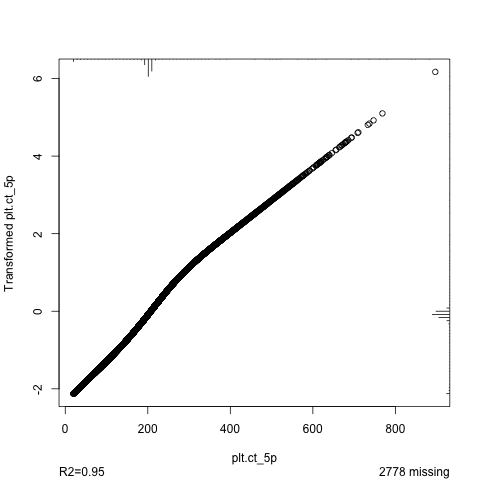

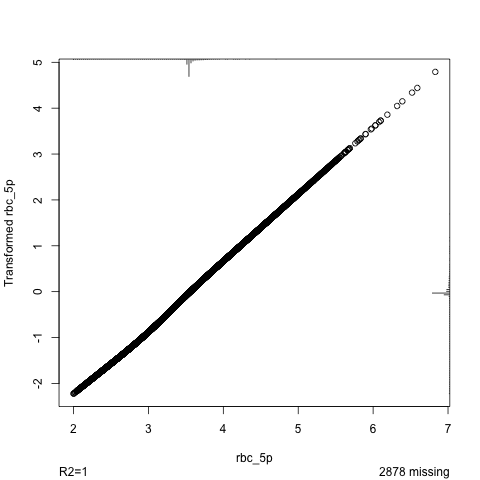

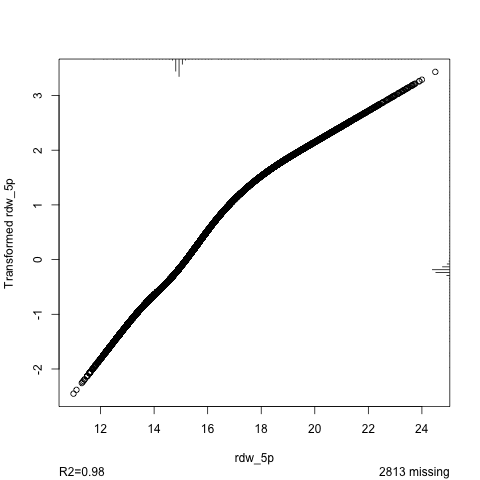

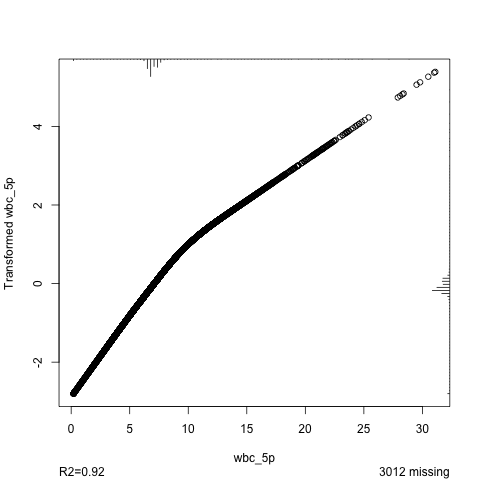

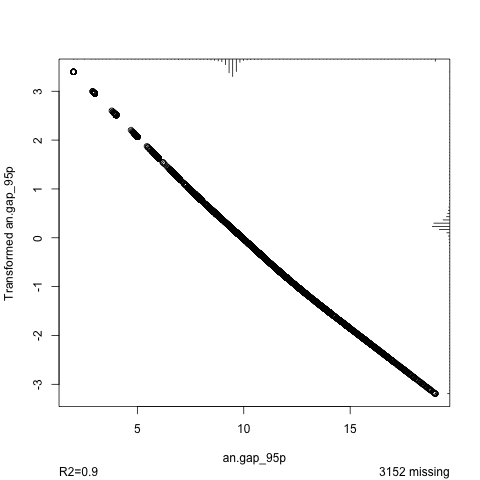

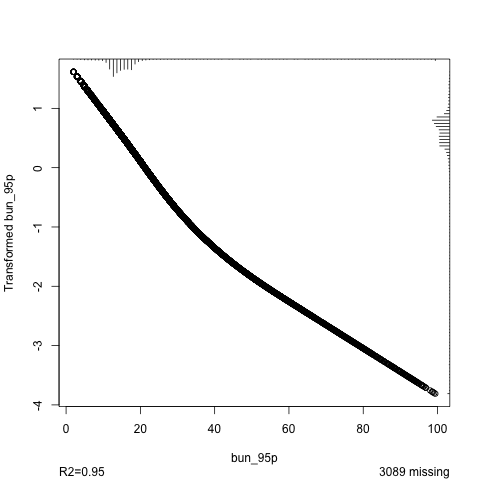

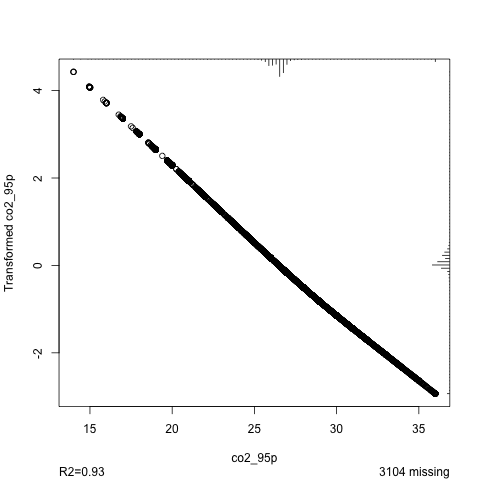

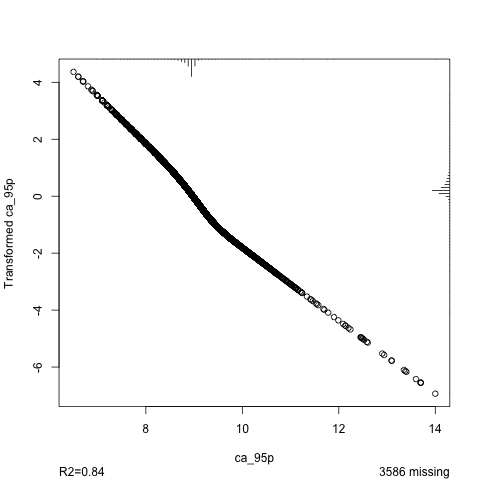

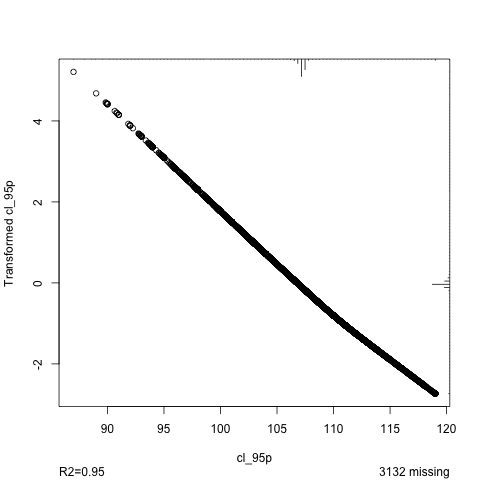

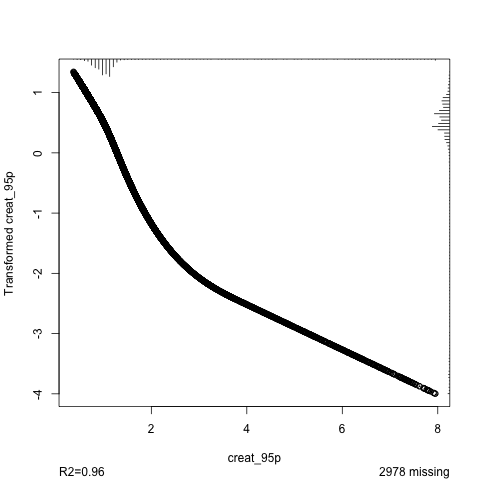

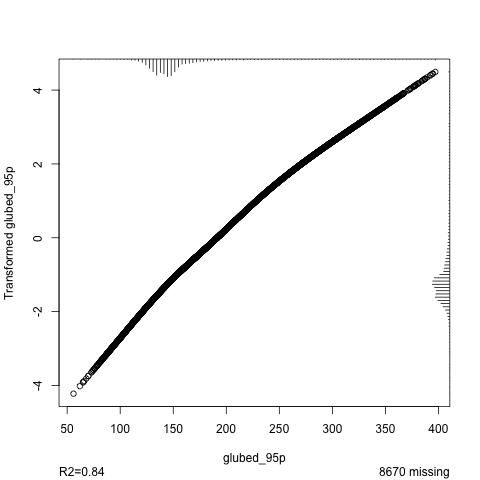

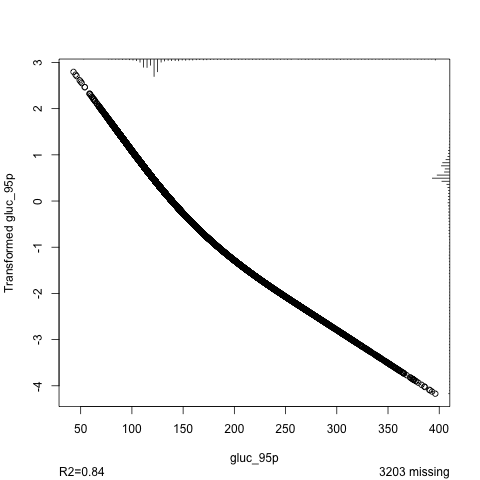

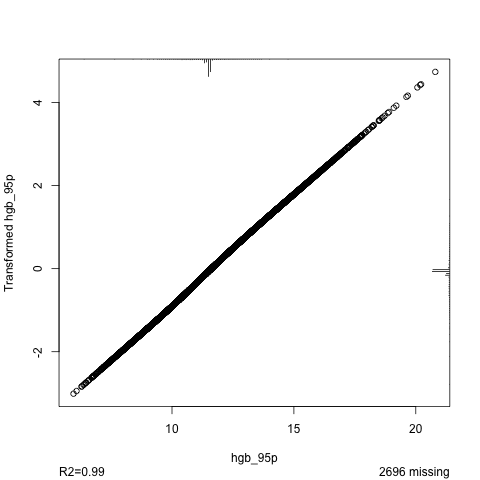

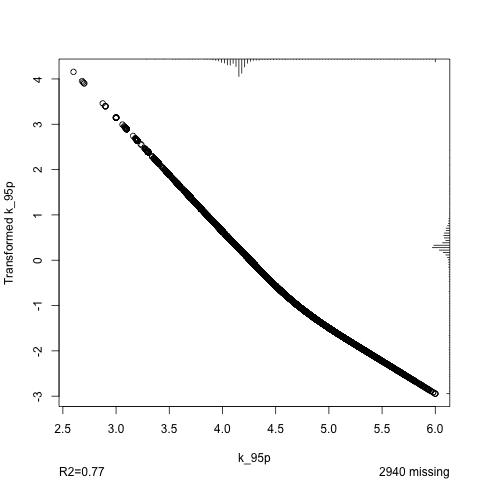

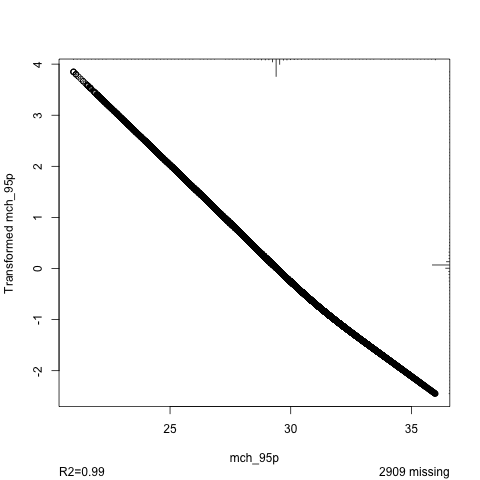

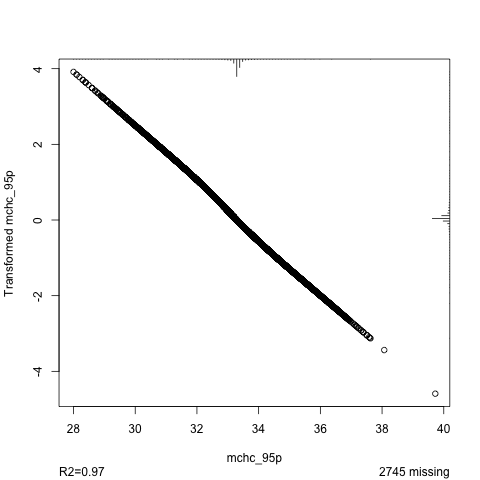

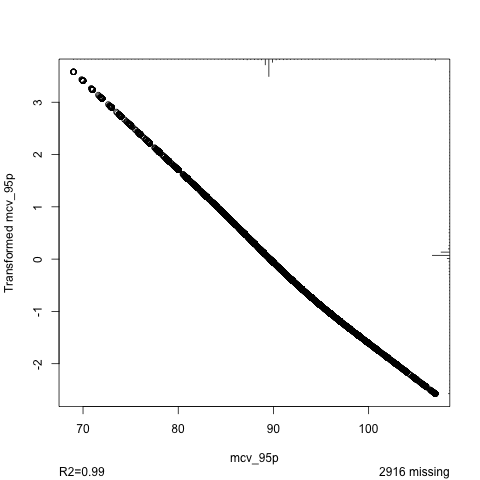

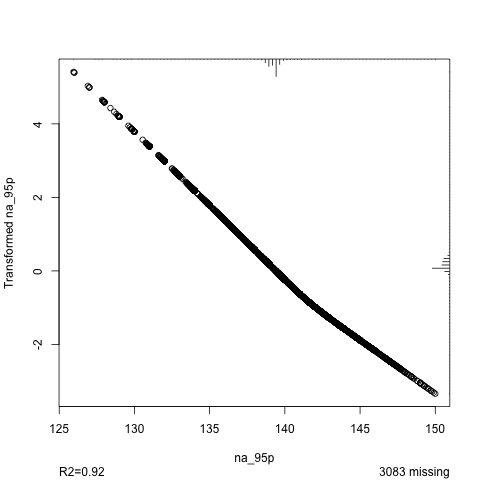

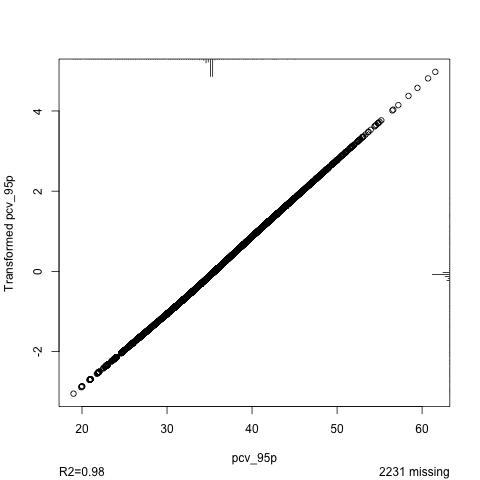

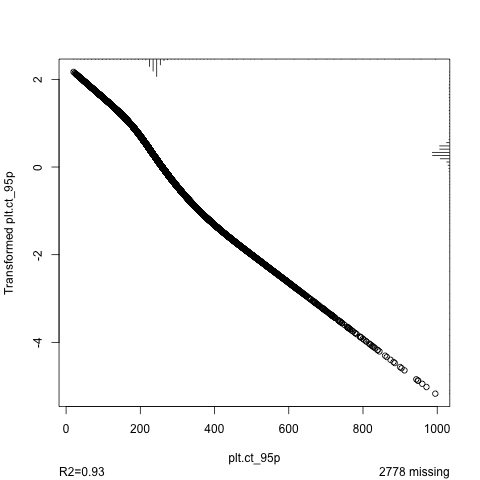

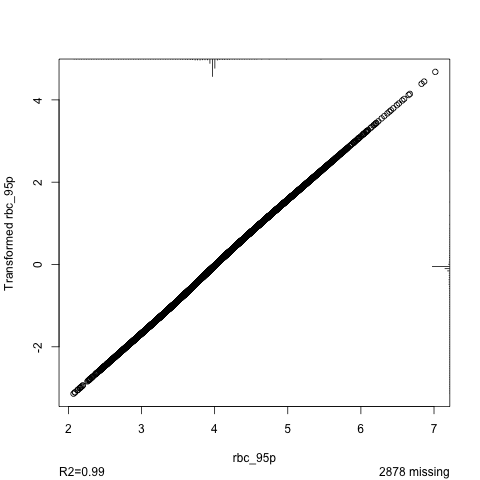

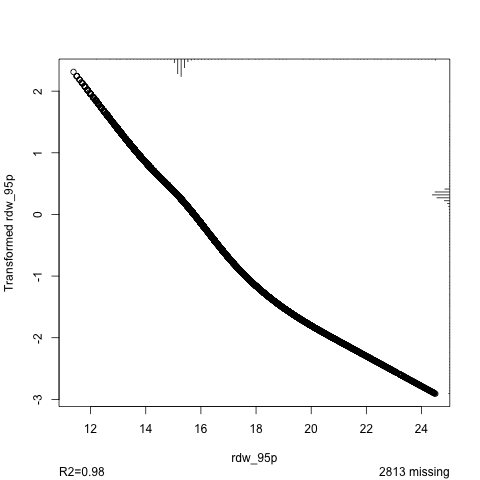

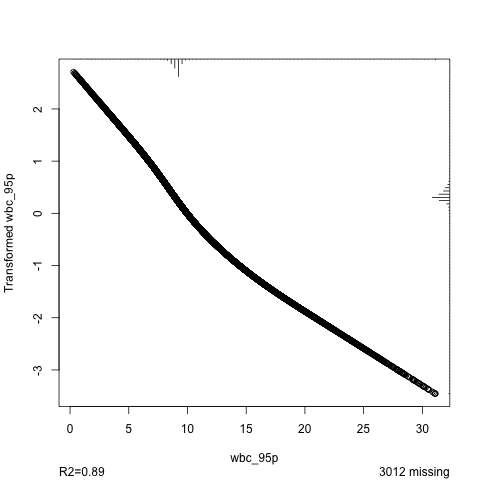

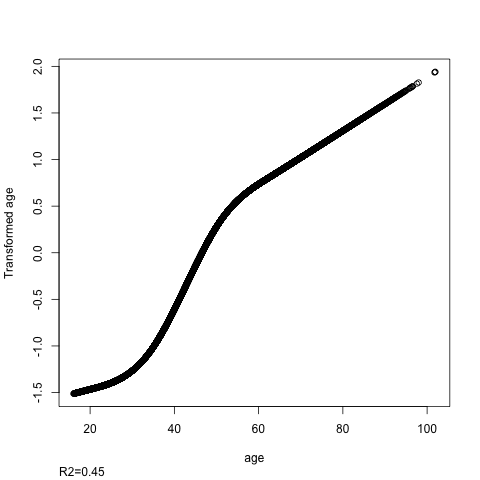

In [12]:
%%R 
# convert all predictors into R formula
vars <- paste(names(train), collapse=' + ')
formula <- as.formula(paste('~', vars))

# perform single imputation using transformed variables & canonical correlation
single_imp <- transcan(formula,
                       categorical=c('readmit_30d', 'sex', 'race'), #, 'pregnancy_indicator'),
                       
                       
                       
                       eps=1, 
                       #iter.max=500, 
                       
                       
                       
                       # variables with fewer than 3 unique knots
                       asis=c('icd_dx_perinatal', 'icd_dx_skin'),
                       transformed=TRUE, 
                       imputed=TRUE, 
                       # if wanting multiple imputations rather than a single:
                       #n.impute=5, 
                       show.na=TRUE, 
                       data=train)

# save to speed up process in case of dead kernel
save(single_imp, file='../data/single_imputation_training.RData')

In [ ]:
#%R summary(single_imp)

In [17]:
%%R -o train_imp
load('../data/single_imputation_training.RData')
train_imp <- data.frame(impute.transcan(single_imp, data=train, list.out=T))



Imputed missing values with the following frequencies
 and stored them in variables with their original names:

an.gap_median    bun_median    co2_median     ca_median     cl_median 
         2613          2619          2502          3225          2602 
 creat_median glubed_median   gluc_median    hgb_median      k_median 
         2441          7692          2551          2535          2363 
   mch_median   mchc_median    mcv_median     na_median    pcv_median 
         2676          2553          2644          2480          1815 
plt.ct_median    rbc_median    rdw_median    wbc_median     an.gap_5p 
         2373          2537          2599          2553          3152 
       bun_5p        co2_5p         ca_5p         cl_5p      creat_5p 
         3089          3104          3586          3132          2978 
    glubed_5p       gluc_5p        hgb_5p          k_5p        mch_5p 
         8670          3203          2696          2940          2909 
      mchc_5p        mcv_5p       

In [18]:
# any remaining NA's? 
assert(sum(train_imp.isnull().sum()>0)==0)
assert(sum(valid_imp.isnull().sum()>0)==0)
assert(sum(test_imp.isnull().sum()>0)==0)

## Save Imputed Sets to Flat Files

In [19]:
%%R 
write.csv(train_imp, file='../data/train_imputed.csv')
write.csv(valid_imp, file='../data/valid_imputed.csv')
write.csv(test_imp, file='../data/test_imputed.csv')